# INTRODUCTION

L'objectif est de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

On se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import datetime as dt
import scipy.stats as st
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from scipy.stats import kruskal
import re
import missingno as msno
from tqdm import tqdm
import locale
import os #intéragir avec le système d'exploitation
import zipfile #lecture et écriture pour les fichiers zip
import urllib #gestion des url
!pip install folium
import folium
from folium.plugins import MarkerCluster
!pip install geopy
from geopy.geocoders import Nominatim
import plotly.express as px
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
import warnings

# IMPORTATION DU JEU DE DONNÉES

In [2]:
def download_data(projet_4, download_root="https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/", resource="2016_Building_Energy_Benchmarking.csv"):
    # Lien du fichier à télécharger
    projet_4_resource = resource
    projet_4_url = download_root + projet_4_resource

    # Création du chemin d'enregistrement du fichier
    projet_4_path = os.path.join("datasets", projet_4)

    def fetch_data(url=projet_4_url, path=projet_4_path):
        if not os.path.isdir(path):
            # Création du répertoire s'il n'existe pas
            os.makedirs(path)
        csv_path = os.path.join(path, projet_4_resource)
        urllib.request.urlretrieve(url, csv_path)

    # Appel de la fonction pour télécharger les données
    fetch_data()

    # Chargeons les données
    def load_data(projet_4_path=projet_4_path):
        csv_path = os.path.join(projet_4_path, projet_4_resource)
        return pd.read_csv(csv_path, low_memory=False)

    return load_data()

In [3]:
data = download_data("projet_4")
display(data.head())

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [4]:
pd.set_option('display.max_column',46)
pd.set_option('display.max_row',150)

# ANALYSE EXPLORATOIRE

**SYNTHESE**

Le fichier contient : 
- 3376 lignes et 46 colonnes
- il y a des 4 types de variables (int, float, object et bool)
- Il y a plusieurs variables quasiment vides

Les données proviennet d'un site gouvernemental, fiable.

Variables cibles : 
- Emission de CO2 : **TotalGHGEmissions**
- Consommation totale d'energie : **SiteEnergyUse**

Les variables 'float' ne sont pas standardisées.

In [5]:
# Fonction affichage des informations du jeu de donnée

def data_information (data) :
    print ("\033[1m" + 'Nombre de ligne :' + "\033[0m", data.shape[0], "\033[1m" + 'Nombre de colonne :' + "\033[0m", data.shape[1])
    print('------')
    print("\033[1m" + 'Types des variables :' + "\033[0m")
    print (data.dtypes.value_counts())
    print('------')
    print("\033[1m" + 'Valeurs manquantes :' + "\033[0m")
    %matplotlib inline
    msno.matrix(data.sample(3376))
    plt.show()
     
    # Regardons le % de valeurs manquantes par colonne
    display((data.isna().sum()/data.shape[0]).sort_values(ascending=False))

Nombre de ligne : 3376 Nombre de colonne : 46
------
Types des variables :
float64    22
object     15
int64       8
bool        1
dtype: int64
------
Valeurs manquantes :


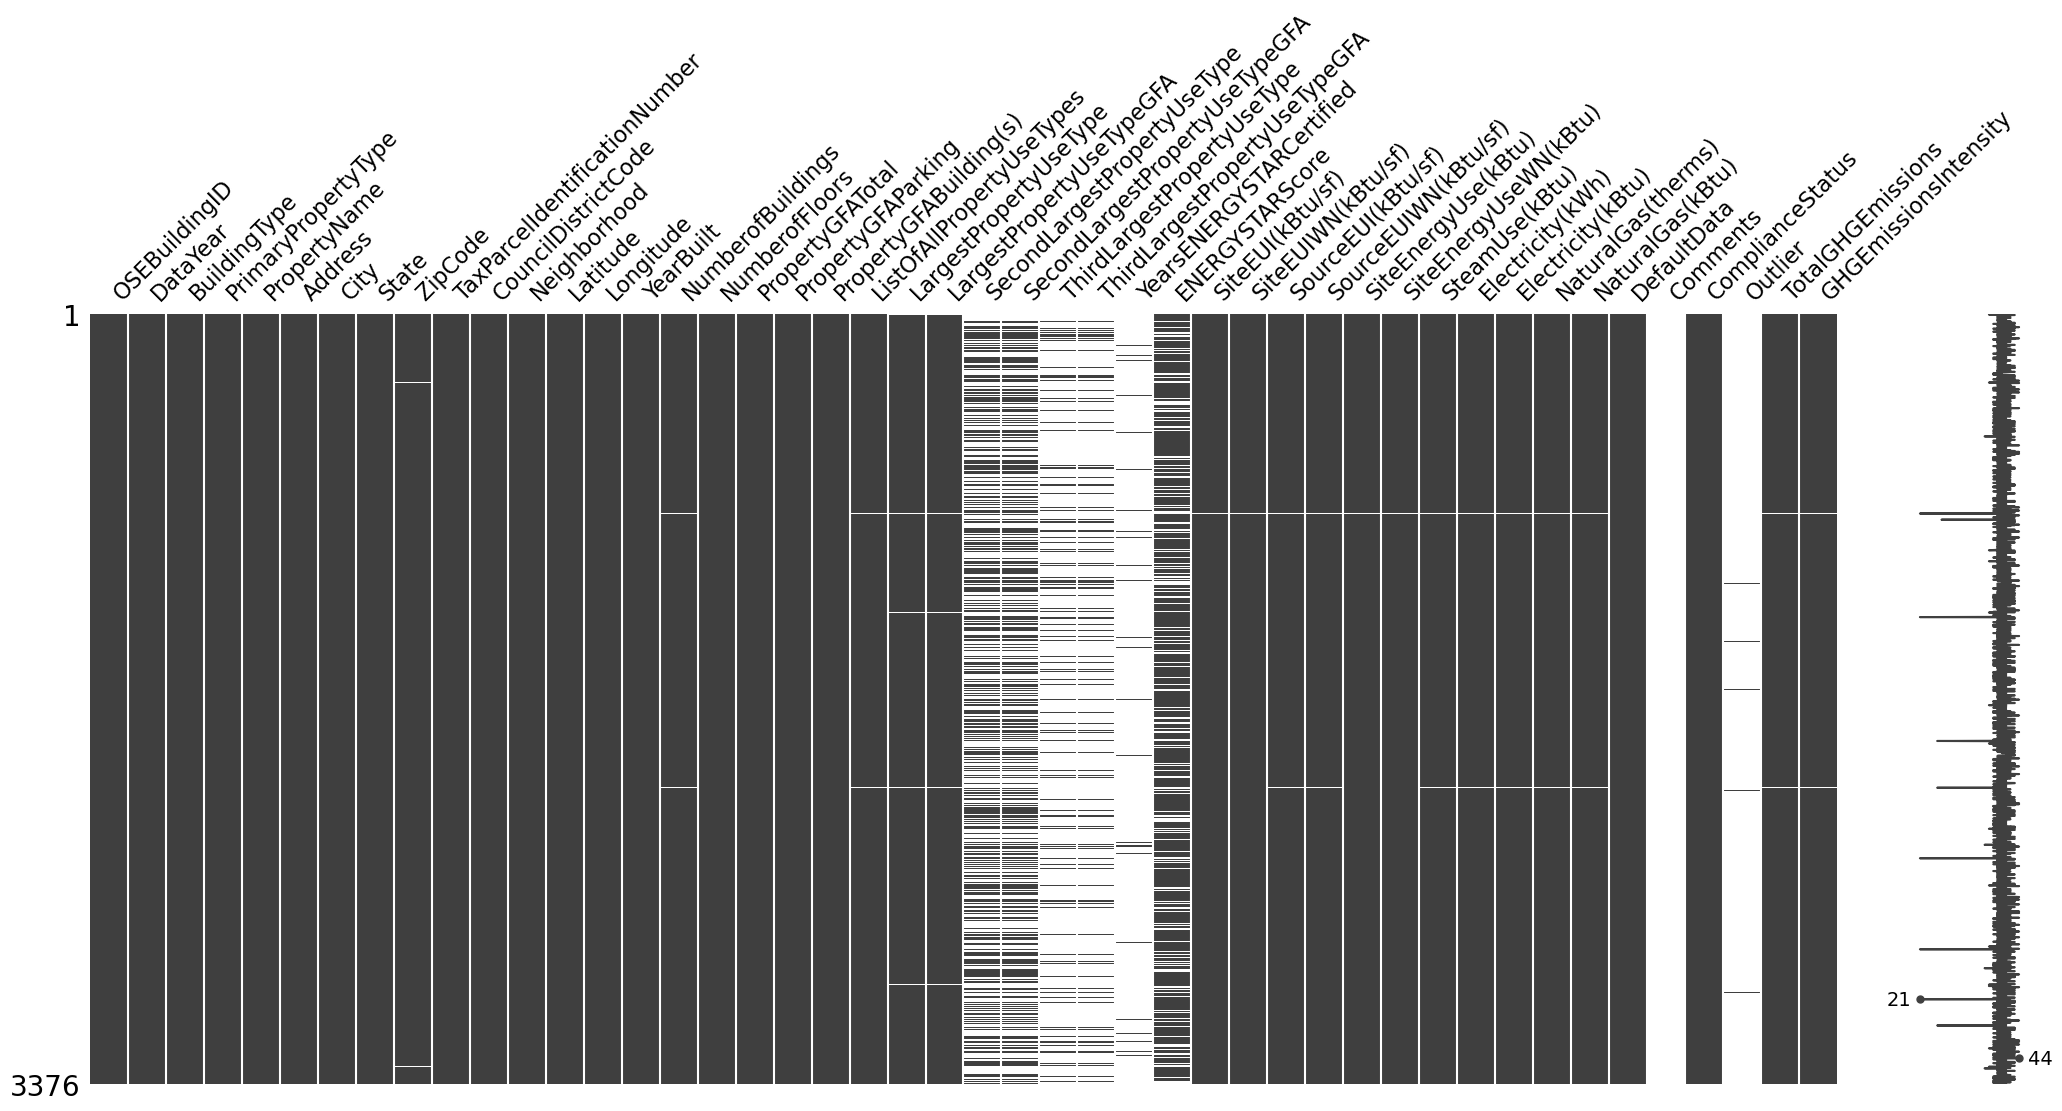

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
ListOfAllPropertyUseTypes          0.002666
SourceEUIWN(kBtu/sf)               0.002666
SourceEUI(kBtu/sf)                 0.002666
Electricity(kWh)                   0.002666
Electricity(kBtu)                  0.002666
NaturalGas(therms)                 0.002666
NaturalGas(kBtu)                   0.002666
TotalGHGEmissions                  0.002666
SteamUse(kBtu)                     0.002666
GHGEmissionsIntensity              0.002666
NumberofBuildings                  0.002370
SiteEUI(kBtu/sf)                

In [6]:
data_information (data)

## Nettoyage des données

1. On regarde les types de batiments, ici nous garderons uniquement les non résidentiels

In [7]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [8]:
data=data.loc[~data['BuildingType'].isin(['Multifamily MR (5-9)', 'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'])]
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Nonresidential WA'],
      dtype=object)

In [9]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


### Valeurs manquantes

1. Suppression des variables entièrement vide 
2. Analyse des variables vides à plus de 24%, on remarque qu'il y a 2 groupes, un avec plus de 24% de valeurs manquantes et un autre avec très peu de valeurs manquantes.

In [10]:
def empty_variables_drop(data, threshold=100):
    for column in data.columns:
        missing_percentage = (data[column].isna().sum() / data[column].shape[0]) * 100
        if missing_percentage >= threshold:
            print(column)
            data.drop(column, axis=1, inplace=True)
    
    return data.shape

In [11]:
# Suppression des variables vides à plus de 100%
empty_variables_drop(data, threshold=100)

Comments


(1546, 45)

In [12]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


In [13]:
def empty_variables(data, threshold=80):
    for column in data.columns:
        missing_percentage = (data[column].isna().sum() / data[column].shape[0]) * 100
        if missing_percentage >= threshold:
            print("\033[1m" + column + "\033[0m",':', 'vide à', "{:.2f}".format(missing_percentage), '%')

In [14]:
empty_variables(data, threshold=24)

SecondLargestPropertyUseType : vide à 45.54 %
SecondLargestPropertyUseTypeGFA : vide à 45.54 %
ThirdLargestPropertyUseType : vide à 77.68 %
ThirdLargestPropertyUseTypeGFA : vide à 77.68 %
YearsENERGYSTARCertified : vide à 94.11 %
ENERGYSTARScore : vide à 34.93 %
Outlier : vide à 98.97 %


In [15]:
data[['LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].dropna().head(10)

LargestPropertyUseType SecondLargestPropertyUseType  \
1                            Hotel                      Parking   
4                            Hotel                      Parking   
15                         Library                      Parking   
16  Fitness Center/Health Club/Gym                       Office   
18             Social/Meeting Hall                   Restaurant   
26                           Hotel                      Parking   
32                          Office                  K-12 School   
36      Non-Refrigerated Warehouse       Refrigerated Warehouse   
42           Self-Storage Facility            Vocational School   
44                          Office                 Retail Store   

              ThirdLargestPropertyUseType  
1                              Restaurant  
4                           Swimming Pool  
15                            Data Center  
16                          Swimming Pool  
18                                 Office  
26                           Retail Store  
32  Other - Entertainment/Public Assembly  
36                                 Office  
42                                 Office  
44                            Data Center

In [16]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


In [17]:
# Liste des colonnes à traiter
columns_to_replace_nan = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

# On remplace les valeurs manquantes par 'None'
for i in columns_to_replace_nan : 
    data[i] = data[i].fillna(value='None')
    print(data[i].unique())

['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Library' 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Courthouse' 'Other' 'College/University' 'Automobile Dealership'
 'Office' 'Self-Storage Facility' 'Non-Refrigerated Warehouse'
 'K-12 School' 'Other - Mall' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital (General Medical & Surgical)' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Other/Specialty Hospital' 'Financial Office' 'Distribution Center'
 'Parking' 'Multifamily Housing' 'Worship Facility' 'Restaurant'
 'Data Center' 'Laboratory' 'Supermarket/Grocery Store'
 'Convention Center' 'Urgent Care/Clinic/Other Outpatient' 'None'
 'Other - Services' 'Strip Mall' 'Wholesale Club/Supercenter'
 'Refrigerated Warehouse' 'Manufacturing/Industrial Plant'
 'Other - Recreation' 'Lifestyle Center' 'Other - Public Services'
 'Other - Education' 'Fire Station' 'Performing A

In [18]:
data[['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']].dropna().head(10)

LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
1                     83880.0                          15064.0   
4                    123445.0                          68009.0   
15                   364913.0                          49000.0   
16                    90000.0                          40000.0   
18                    16442.0                          15505.0   
26                   112676.0                          42000.0   
32                    40943.0                          18153.0   
36                   616000.0                         276000.0   
42                    38439.0                          28197.0   
44                   103362.0                          65676.0   

    ThirdLargestPropertyUseTypeGFA  
1                           4622.0  
4                              0.0  
15                          1074.0  
16                             0.0  
18                          9741.0  
26                          4500.0  
32                          4307.0  
36                         71000.0  
42                          3859.0  
44                           493.0

In [19]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


In [20]:
# Liste des colonnes à traiter
columns_to_replace_nan = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

# On remplace les valeurs manquantes par '0'
for i in columns_to_replace_nan : 
    data[i] = data[i].fillna(value=0)
    print(data[i].isnull().value_counts())

False    1546
Name: LargestPropertyUseTypeGFA, dtype: int64
False    1546
Name: SecondLargestPropertyUseTypeGFA, dtype: int64
False    1546
Name: ThirdLargestPropertyUseTypeGFA, dtype: int64


In [21]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


In [22]:
empty_variables(data, threshold=24)

YearsENERGYSTARCertified : vide à 94.11 %
ENERGYSTARScore : vide à 34.93 %
Outlier : vide à 98.97 %


In [23]:
data[['YearsENERGYSTARCertified']].dropna().head(10)

YearsENERGYSTARCertified
44                                       2016
53                                       2014
204                                      2012
206                                  20172015
207  2017201620152014201320122011201020092008
209                              201020092007
211                              201720102007
212                                  20162015
214                                  20172015
218                      20152014201220112009

In [24]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


In [25]:
data[['ENERGYSTARScore']].dropna().head(10)

ENERGYSTARScore
0              60.0
1              61.0
2              43.0
3              56.0
4              75.0
6              27.0
8              43.0
10             30.0
11             36.0
12             48.0

In [26]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1546


In [27]:
data['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [28]:
data[data['Outlier']=='High outlier'].head(10)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
226            350      2016  NonResidential        Large Office   
517            704      2016  NonResidential        Large Office   

                   PropertyName              Address     City State  ZipCode  \
226  Second And Spring Building   1100 Second Avenue  Seattle    WA  98101.0   
517        401 Elliott Ave West  401 Elliot Ave West  Seattle    WA  98119.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
226                    0942000045                    7               DOWNTOWN   
517                    7666202110                    7  MAGNOLIA / QUEEN ANNE   

     Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
226  47.60642 -122.33581       1958                1.0               6   
517  47.62235 -122.36378       2000                1.0               4   

     PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
226            172842               25920                  146922   
517            129551               42500                   87051   

        ListOfAllPropertyUseTypes LargestPropertyUseType  \
226  Data Center, Office, Parking                 Office   
517  Data Center, Office, Parking                 Office   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
226                    99890.0                  Data Center   
517                    82273.0                      Parking   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
226                          39336.0                     Parking   
517                          42500.0                 Data Center   

     ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
226                         25000.0                      NaN              NaN   
517                          4778.0                      NaN              1.0   

     SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
226        297.399994          299.200012          909.599976   
517        311.700012          311.700012          978.900024   

     SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
226            911.500000           41399504.0             41650404.0   
517            978.900024           27137190.0             27137190.0   

     SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
226             0.0        11663150.0         39794668.0         16048.30957   
517             0.0         7953454.5         27137187.0             0.00000   

     NaturalGas(kBtu)  DefaultData ComplianceStatus       Outlier  \
226         1604831.0        False    Non-Compliant  High outlier   
517               0.0        False    Non-Compliant  High outlier   

     TotalGHGEmissions  GHGEmissionsIntensity  
226             362.66                   2.10  
517             189.18                   1.46

In [29]:
data=data.loc[~data['Outlier'].isin(['High outlier', 'Low outlier'])]
data['Outlier'].unique()

array([nan], dtype=object)

In [30]:
data=data.drop(['Outlier'], axis=1)

In [31]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1530


In [32]:
empty_variables(data, threshold=24)

YearsENERGYSTARCertified : vide à 94.05 %
ENERGYSTARScore : vide à 34.90 %


### Doublons

In [33]:
# Recherche de doublons + traitement
def doublons (data) :
    doublons = data[data.duplicated()]
    return doublons

In [34]:
doublons(data)

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [35]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1530


### Description des variables

In [36]:
display(data.describe(include=[float]))
display(data.describe(include=[object]))
display(data.describe(include=[int]))
display(data.describe(include=[bool]))

ZipCode     Latitude    Longitude  NumberofBuildings  \
count   1514.000000  1530.000000  1530.000000        1528.000000   
mean   98116.672391    47.616397  -122.333426           1.034031   
std       18.581940     0.046860     0.023199           0.563127   
min    98006.000000    47.509590  -122.411820           0.000000   
25%    98104.000000    47.587825  -122.342815           1.000000   
50%    98109.000000    47.612615  -122.333045           1.000000   
75%    98125.000000    47.648962  -122.322620           1.000000   
max    98199.000000    47.733870  -122.261800           9.000000   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.530000e+03                      1530.000000   
mean                9.053592e+04                     19596.919802   
std                 1.566849e+05                     52294.000725   
min                 0.000000e+00                         0.000000   
25%                 2.453700e+04                         0.000000   
50%                 4.126550e+04                         0.000000   
75%                 8.879700e+04                     13593.250000   
max                 1.680937e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count                     1530.000000       996.000000       1527.000000   
mean                      2993.653202        63.567269         74.499476   
std                      14367.205185        28.787708         75.252973   
min                          0.000000         1.000000          0.000000   
25%                          0.000000        44.000000         34.700001   
50%                          0.000000        70.500000         53.400002   
75%                          0.000000        88.000000         83.950001   
max                     303910.000000       100.000000        834.400024   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count         1527.000000         1528.000000           1528.000000   
mean            76.902751          182.138285            184.387304   
std             76.244282          188.454616            188.431862   
min              0.000000            0.000000             -2.100000   
25%             36.699999           81.000000             82.999998   
50%             56.000000          138.250000            141.050003   
75%             87.549999          211.224998            212.474995   
max            834.400024         2620.000000           2620.000000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count         1.528000e+03           1.527000e+03    1.528000e+03   
mean          7.668847e+06           7.777302e+06    5.003335e+05   
std           1.871642e+07           1.887938e+07    5.333607e+06   
min           0.000000e+00           0.000000e+00    0.000000e+00   
25%           1.217961e+06           1.285880e+06    0.000000e+00   
50%           2.644280e+06           2.759012e+06    0.000000e+00   
75%           6.986487e+06           7.227405e+06    0.000000e+00   
max           2.930908e+08           2.966717e+08    1.349435e+08   

       Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
count      1.528000e+03       1.528000e+03        1.528000e+03   
mean       1.593603e+06       5.437375e+06        1.686001e+04   
std        3.826398e+06       1.305567e+07        5.531158e+04   
min       -3.382680e+04      -1.154170e+05        0.000000e+00   
25%        2.110412e+05       7.200730e+05        0.000000e+00   
50%        4.913763e+05       1.676576e+06        4.477668e+03   
75%        1.486967e+06       5.073530e+06        1.425970e+04   
max        8.046087e+07       2.745325e+08        1.381912e+06   

       NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
count      1.528000e+03        1528.000000            1528.000000  
mean       1.686001e+06         166.069346               1.621191  
std        5.531158e+06        

BuildingType          PrimaryPropertyType PropertyName  \
count             1530                         1530         1530   
unique               3                           22         1527   
top     NonResidential  Small- and Mid-Sized Office  Airport Way   
freq              1445                          289            2   

                            Address     City State  \
count                          1530     1530  1530   
unique                         1509        1     1   
top     309 South Cloverdale Street  Seattle    WA   
freq                              4     1530  1530   

       TaxParcelIdentificationNumber Neighborhood ListOfAllPropertyUseTypes  \
count                           1530         1530                      1528   
unique                          1452           19                       363   
top                       1625049001     DOWNTOWN                    Office   
freq                               7          350                       135   

       LargestPropertyUseType SecondLargestPropertyUseType  \
count                    1530                         1530   
unique                     57                           48   
top                    Office                         None   
freq                      489                          695   

       ThirdLargestPropertyUseType YearsENERGYSTARCertified ComplianceStatus  
count                         1530                       91             1530  
unique                          39                       64                4  
top                           None                     2016        Compliant  
freq                          1187                        5             1514

OSEBuildingID  DataYear  CouncilDistrictCode    YearBuilt  \
count    1530.000000    1530.0          1530.000000  1530.000000   
mean    16571.745752    2016.0             4.421569  1961.509150   
std     13867.218078       0.0             2.191471    32.808683   
min         1.000000    2016.0             1.000000  1900.000000   
25%       609.250000    2016.0             2.000000  1930.000000   
50%     21187.500000    2016.0             4.000000  1965.000000   
75%     24627.750000    2016.0             7.000000  1988.000000   
max     50226.000000    2016.0             7.000000  2015.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     1530.000000      1.530000e+03         1530.000000   
mean         4.299346      1.123646e+05        13922.816993   
std          6.814697      1.923610e+05        43880.605319   
min          0.000000      1.128500e+04            0.000000   
25%          1.000000      2.880000e+04            0.000000   
50%          2.000000      4.748450e+04            0.000000   
75%          4.000000      1.029825e+05            0.000000   
max         99.000000      1.952220e+06       512608.000000   

       PropertyGFABuilding(s)  
count            1.530000e+03  
mean             9.844175e+04  
std              1.689863e+05  
min              3.636000e+03  
25%              2.774800e+04  
50%              4.521300e+04  
75%              9.330275e+04  
max              1.765970e+06

DefaultData
count         1530
unique           2
top          False
freq          1518

In [37]:
data.sort_values(by='NumberofBuildings', ascending=False).head()

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
170             276      2016      NonResidential            Hospital   
1672          23071      2016      NonResidential            Hospital   
3168          49705      2016  Nonresidential COS               Other   
618             828      2016      NonResidential            Hospital   
364             516      2016      NonResidential               Other   

                   PropertyName                          Address     City  \
170   Harborview Medical Center                     325 9th Ave.  Seattle   
1672  Main Hospital - All Wings  Facilities Management MS: B-120  Seattle   
3168                   Magnuson           7400 Sand Point Way NE  Seattle   
618          Swedish First Hill                     747 Broadway  Seattle   
364      Aurora Shopping Center        13201 Aurora Avenue North  Seattle   

     State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
170     WA  98104.0                    8590900220                    3   
1672    WA  98133.0                    3026049130                    5   
3168    WA  98115.0                    0225049062                    4   
618     WA  98122.0                    1978201096                    3   
364     WA  98133.0                    1926049215                    5   

     Neighborhood   Latitude   Longitude  YearBuilt  NumberofBuildings  \
170          EAST  47.603990 -122.323770       2000                9.0   
1672    NORTHWEST  47.714250 -122.336890       1966                8.0   
3168    NORTHEAST  47.682120 -122.263300       1929                8.0   
618          EAST  47.608951 -122.322402       1994                7.0   
364     NORTHWEST  47.725460 -122.346590       1964                6.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
170                8           1158691                   0   
1672               1            415632                   0   
3168               0            502030                   0   
618               14           1765970                   0   
364                1            111900                   0   

      PropertyGFABuilding(s)                       ListOfAllPropertyUseTypes  \
170                  1158691  Hospital (General Medical & Surgical), Parking   
1672                  415632  Hospital (General Medical & Surgical), Parking   
3168                  502030                              Other - Recreation   
618                  1765970  Hospital (General Medical & Surgical), Parking   
364                   111900                             Parking, Strip Mall   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
170   Hospital (General Medical & Surgical)                  1350182.0   
1672  Hospital (General Medical & Surgical)                   483520.0   
3168                     Other - Recreation                   564258.0   
618   Hospital (General Medical & Surgical)                  1639334.0   
364                              Strip Mall                   124231.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
170                       Parking                         387651.0   
1672                      Parking                         266833.0   
3168                         None                              0.0   
618                       Parking                         441551.0   
364                       Parking                              0.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
170                         None                             0.0   
1672                        None                             0.0   
3168                        None                             0.0   
618                         None                             0.0   
364                         None                             0.0   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
170              

In [38]:
data = data.loc[~(data['NumberofBuildings'] > 3)]
print(data['NumberofBuildings'].unique())

[ 1.  3.  0.  2. nan]


In [39]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'CENTRAL',
       'SOUTHWEST', 'SOUTHEAST', 'NORTH', 'DELRIDGE', 'North', 'Delridge',
       'Ballard', 'Northwest', 'Central', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [40]:
def lexical_categorie_norm(column_name):
    # Normaliser la colonne spécifiée
    data[column_name] = data[column_name].str.title()
    data[column_name] = data[column_name].str.replace('Neighborhoods', '').str.strip()
    
    # Afficher les catégories uniques
    categories_uniques = data[column_name].unique()
    print(categories_uniques)

In [41]:
lexical_categorie_norm('Neighborhood')

['Downtown' 'Northeast' 'East' 'Lake Union' 'Greater Duwamish' 'Ballard'
 'Northwest' 'Magnolia / Queen Anne' 'Central' 'Southwest' 'Southeast'
 'North' 'Delridge']


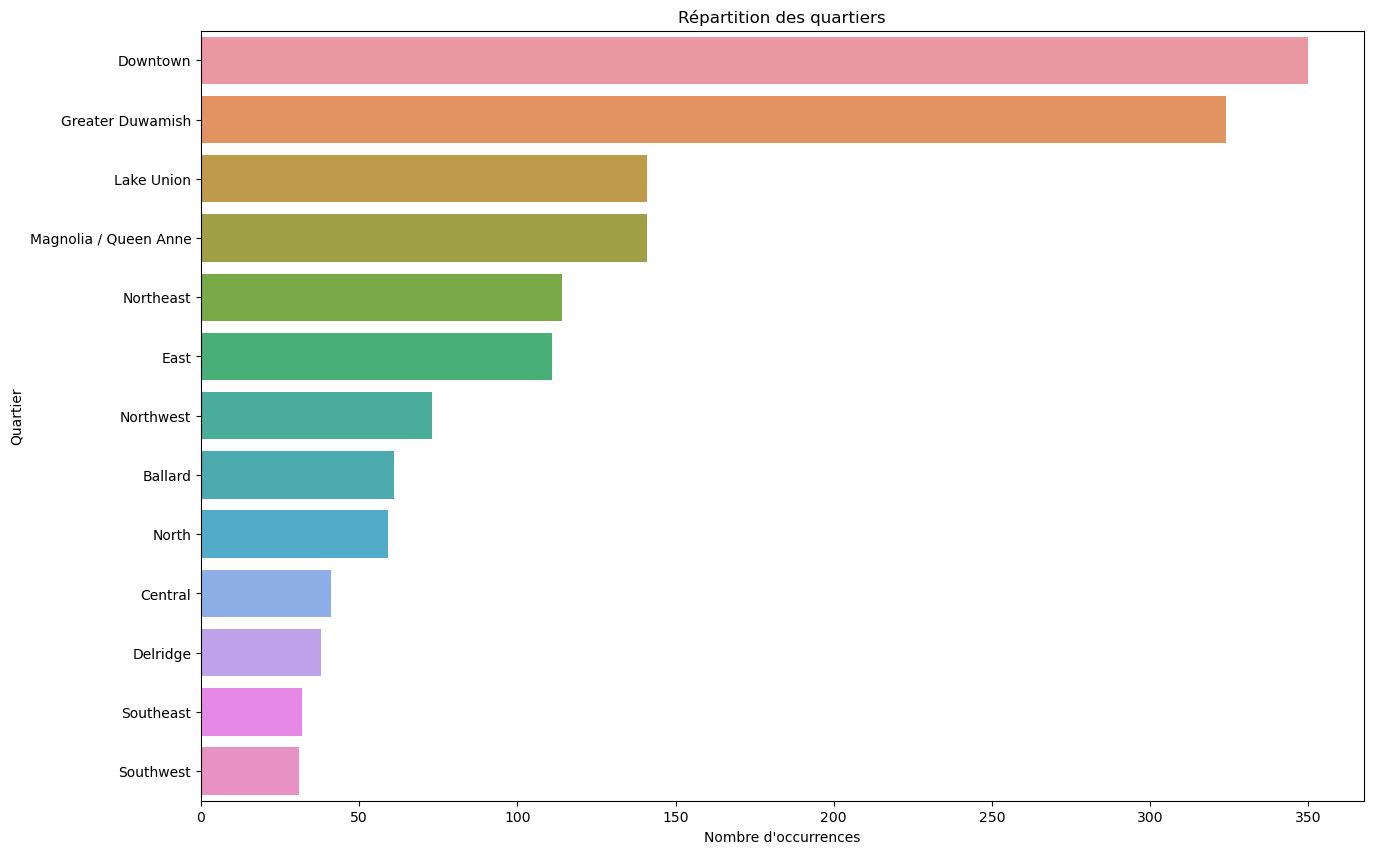

In [42]:
# Regardons la répartition des quartiers
neighborhood_counts = data['Neighborhood'].value_counts()

plt.figure(figsize=(15,10))
sns.barplot(y=neighborhood_counts.index, x=neighborhood_counts)
plt.title('Répartition des quartiers')
plt.ylabel('Quartier')
plt.xlabel('Nombre d\'occurrences')
plt.show()

In [43]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Residence Hall', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory', 'Hospital',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily',
       'Office'], dtype=object)

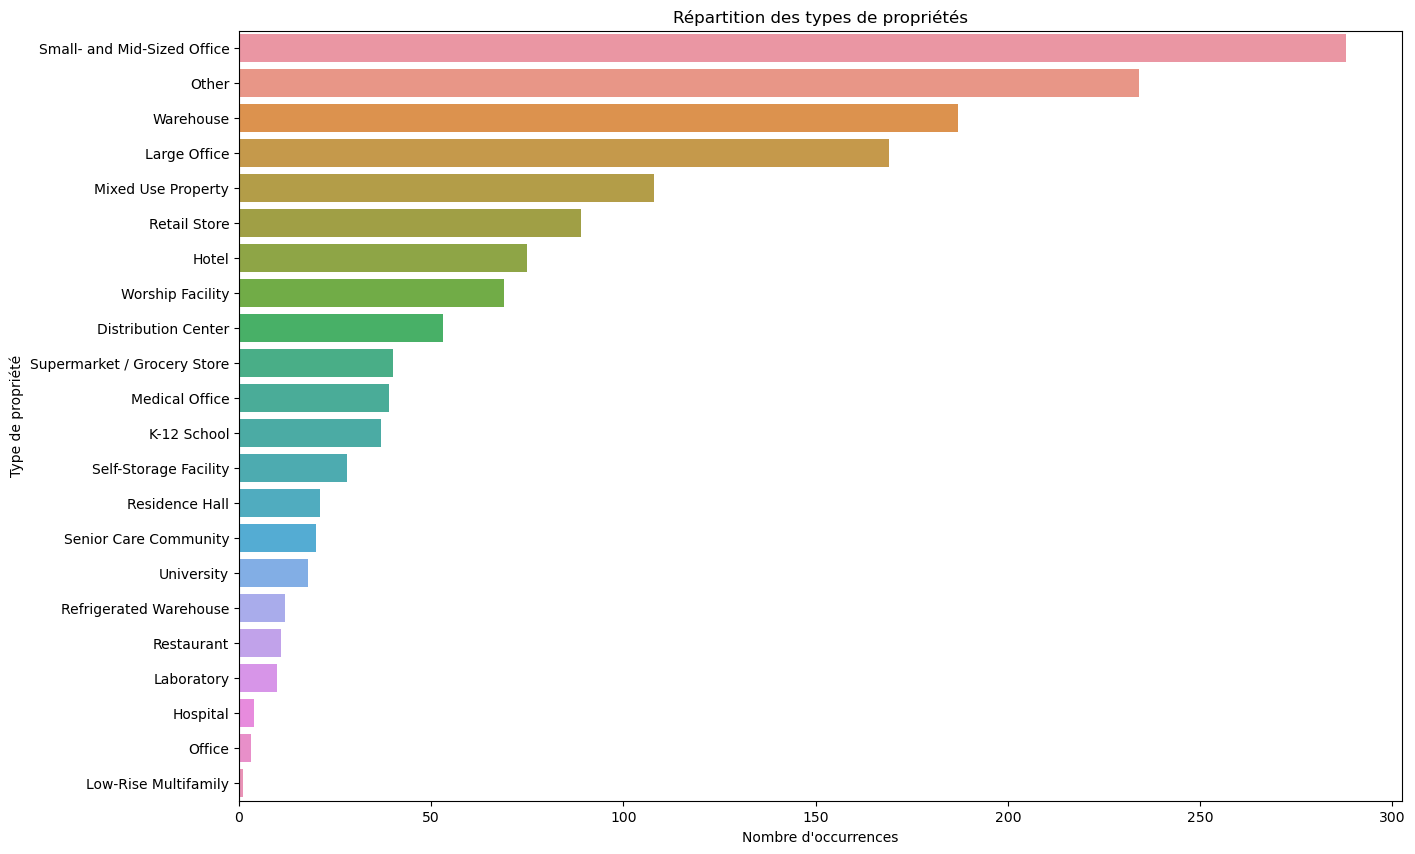

In [44]:
# Regardons la répartition types de propriétés
PrimaryPropertyType_counts = data['PrimaryPropertyType'].value_counts()

plt.figure(figsize=(15,10))
sns.barplot(y=PrimaryPropertyType_counts.index, x=PrimaryPropertyType_counts)
plt.title('Répartition des types de propriétés')
plt.ylabel('Type de propriété')
plt.xlabel('Nombre d\'occurrences')
plt.show()

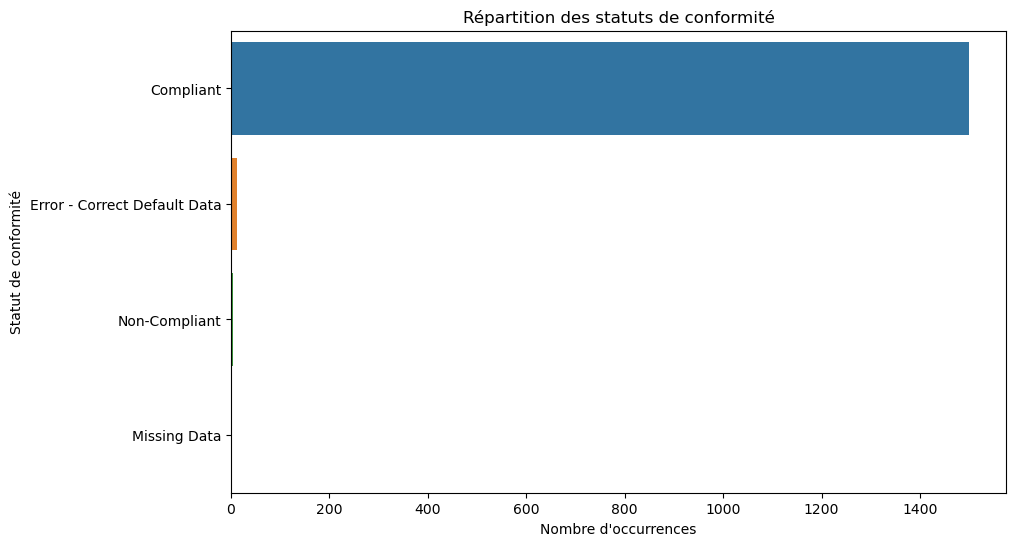

In [45]:
ComplianceStatus_counts = data['ComplianceStatus'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(y=ComplianceStatus_counts.index, x=ComplianceStatus_counts)
plt.title('Répartition des statuts de conformité')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Statut de conformité')
plt.show()

In [46]:
# Regardons la variable ComplianceStatus - error 
data[data['ComplianceStatus']=='Error - Correct Default Data'].head()

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
276             405      2016  NonResidential                 Large Office   
457             618      2016  NonResidential  Small- and Mid-Sized Office   
1466          21898      2016  NonResidential                    Warehouse   
1467          21902      2016  NonResidential                    Warehouse   
1641          22953      2016  NonResidential                 Retail Store   

              PropertyName                 Address     City State  ZipCode  \
276            The Decatur         1511 6th Avenue  Seattle    WA  98101.0   
457            Prefontaine    110 Prefontaine Pl S  Seattle    WA  98104.0   
1466  Halfon Candy Company  9229 10th Avenue South  Seattle    WA  98108.0   
1467                Samson     9928 10th Ave South  Seattle    WA  98108.0   
1641              Tux Shop        10716 5th Ave NE  Seattle    WA  98125.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode      Neighborhood  \
276                     1975700125                    7          Downtown   
457                     5247801045                    7          Downtown   
1466                    2433700076                    1  Greater Duwamish   
1467                    2433700165                    1  Greater Duwamish   
1641                    2926049039                    5             North   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
276   47.61166 -122.33528       1921                1.0               4   
457   47.60159 -122.32915       1909                1.0               6   
1466  47.51968 -122.32120       1978                1.0               1   
1467  47.51918 -122.31957       1979                1.0               1   
1641  47.70747 -122.32249       1965                1.0               1   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
276             127268                   0                  127268   
457              73470                   0                   73470   
1466             31300                   0                   31300   
1467             22000                   0                   22000   
1641             24982                   0                   24982   

                             ListOfAllPropertyUseTypes  \
276   Non-Refrigerated Warehouse, Office, Retail Store   
457   Non-Refrigerated Warehouse, Office, Retail Store   
1466                        Non-Refrigerated Warehouse   
1467               Non-Refrigerated Warehouse, Parking   
1641                                      Retail Store   

          LargestPropertyUseType  LargestPropertyUseTypeGFA  \
276                       Office                    62512.0   
457                       Office                    47145.0   
1466  Non-Refrigerated Warehouse                    31300.0   
1467  Non-Refrigerated Warehouse                    22000.0   
1641                Retail Store                    24982.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
276                  Retail Store                          53971.0   
457    Non-Refrigerated Warehouse                           9477.0   
1466                         None                              0.0   
1467                      Parking                              0.0   
1641                         None                              0.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
276   Non-Refrigerated Warehouse                          5000.0   
457                 Retail Store                          9477.0   
1466                        None                             0.0   
1467                        None                             0.0   
1641                        None                             0.0   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
276                       NaN             71.0         63.500000   
457                       NaN          

In [47]:
print(data['DefaultData'].value_counts())
print(data['ComplianceStatus'].value_counts())

# On regarde si les 2 variables sont liées
subset_default_data_true = data[data['DefaultData'] == True]
subset_error_correct_default_data = data[data['ComplianceStatus'] == 'Error - Correct Default Data']
are_equal = subset_default_data_true.index.equals(subset_error_correct_default_data.index)
print(f"Les lignes avec DefaultData=True sont les mêmes que les lignes avec ComplianceStatus='Error - Correct Default Data': {are_equal}")

False    1504
True       12
Name: DefaultData, dtype: int64
Compliant                       1500
Error - Correct Default Data      12
Non-Compliant                      3
Missing Data                       1
Name: ComplianceStatus, dtype: int64
Les lignes avec DefaultData=True sont les mêmes que les lignes avec ComplianceStatus='Error - Correct Default Data': True


In [48]:
# Suppression des batiments 
data = data[~(data['DefaultData'] == True)]
print(data['DefaultData'].value_counts())

False    1504
Name: DefaultData, dtype: int64


In [49]:
data=data.drop('DefaultData', axis=1)

In [50]:
data.drop(data[data['ComplianceStatus'] == 'Non-Compliant'].index, inplace=True)

In [51]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1501


**SYNTHESE**

- On suppprime la variable 'Comments' qui est entièrement vide
- La variable 'ThirdLargestPropertyUseType' représente la 3ième utilisation des propriétés, on remplira les valeurs manquantes avec 'None'. On fait de même avec 'LargestPropertyUseType' et 'SecondLargestPropertyUseType'
- Les variables sur l'utilisation des propriétés en terme de surface (on a pas d'indication pour le moment sur l'unité de mesure). Si valeurs non connues on remplace par 0. 
- YearsENERGYSTARCertified : correspond à l'année où le batiment a reçu la certification  ENERGY STAR. On gardera cette variable. On la transformera si besoin pour plus de lisibilité.
- ENERGYSTARScore : On gardera la variable sur le score energetique des batiments tel quel
- On supprimera les batiments avec une valeur pour Outlier qui n'est pas NaN, puis on supprime la variable Outlier
- Il n'y a pas de doublons dans la base de donnée.
- La latitude et longitude n'ont pas d'outliers. (les batiments se situent bien à Seattle)
- NumberofBuildings : correspond au nombre de batiment par adresse. On peut voir que la valeur max est de 9 ce qui n'est pas normal. On applique une condition : le maximum autorisé est 3
- La variable Neighborhood recense les quartiers de la ville de Seattle. Il y a 19 quartiers représentés dans notre jeu de donnée. On remarque des erreurs lexicals que l'on corrige.
- La variable 'ComplianceStatus' affiche le statut de conformité de chaque batiment. Il y a une valeur 'Error - Correct Default Data' qui correspond au fait que le batiment a utilisé au moins 1 fois une valeur par défaut. On supprimera donc ces 12 batiments
- On supprime également les bâtiments qui n'ont pas le statut de conformité
- Suppression de la variable DefaultData

## Variables quantitatives

In [52]:
display(data.describe(include=[float]))
display(data.describe(include=[int]))

ZipCode     Latitude    Longitude  NumberofBuildings  \
count   1488.000000  1501.000000  1501.000000        1501.000000   
mean   98116.696237    47.616271  -122.333699           0.988008   
std       18.685748     0.046642     0.023029           0.265561   
min    98006.000000    47.509590  -122.411820           0.000000   
25%    98104.000000    47.587810  -122.342930           1.000000   
50%    98109.000000    47.612750  -122.333180           1.000000   
75%    98125.000000    47.648660  -122.323030           1.000000   
max    98199.000000    47.733870  -122.261800           3.000000   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.501000e+03                      1501.000000   
mean                8.724110e+04                     18563.371284   
std                 1.441763e+05                     47145.581487   
min                 0.000000e+00                         0.000000   
25%                 2.460000e+04                         0.000000   
50%                 4.130800e+04                         0.000000   
75%                 8.849000e+04                     13534.000000   
max                 1.680937e+06                    438756.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count                     1501.000000       977.000000       1501.000000   
mean                      3024.114190        63.556807         74.161026   
std                      14497.986923        28.759551         75.137450   
min                          0.000000         1.000000          0.000000   
25%                          0.000000        44.000000         34.599998   
50%                          0.000000        70.000000         53.400002   
75%                          0.000000        88.000000         83.699997   
max                     303910.000000       100.000000        834.400024   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count         1500.000000         1501.000000           1501.000000   
mean            76.650600          181.798068            184.160093   
std             76.199306          188.975346            189.106369   
min              0.000000            0.000000             -2.100000   
25%             36.749999           80.800003             82.699997   
50%             56.000000          138.000000            140.699997   
75%             87.325003          210.600006            211.300003   
max            834.400024         2620.000000           2620.000000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count         1.501000e+03           1.500000e+03    1.501000e+03   
mean          6.993194e+06           7.102446e+06    3.372928e+05   
std           1.367128e+07           1.375943e+07    2.635146e+06   
min           0.000000e+00           0.000000e+00    0.000000e+00   
25%           1.219863e+06           1.293143e+06    0.000000e+00   
50%           2.640980e+06           2.757506e+06    0.000000e+00   
75%           6.960904e+06           7.094080e+06    0.000000e+00   
max           2.746822e+08           2.747260e+08    7.388547e+07   

       Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
count      1.501000e+03       1.501000e+03         1501.000000   
mean       1.503804e+06       5.130981e+06        14789.710779   
std        3.366679e+06       1.148711e+07        33515.215550   
min       -3.382680e+04      -1.154170e+05            0.000000   
25%        2.119694e+05       7.232400e+05            0.000000   
50%        4.865077e+05       1.659964e+06         4504.796875   
75%        1.468084e+06       5.009101e+06        14089.684570   
max        8.046087e+07       2.745325e+08       546713.937500   

       NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
count      1.501000e+03        1501.000000            1501.000000  
mean       1.478971e+06         140.353258               1.600959  
std        3.351522e+06        

OSEBuildingID  DataYear  CouncilDistrictCode    YearBuilt  \
count    1501.000000    1501.0          1501.000000  1501.000000   
mean    16502.571619    2016.0             4.426382  1961.459027   
std     13795.481924       0.0             2.195619    32.887959   
min         1.000000    2016.0             1.000000  1900.000000   
25%       609.000000    2016.0             2.000000  1929.000000   
50%     21180.000000    2016.0             4.000000  1965.000000   
75%     24603.000000    2016.0             7.000000  1988.000000   
max     50226.000000    2016.0             7.000000  2015.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     1501.000000      1.501000e+03         1501.000000   
mean         4.321785      1.092252e+05        14166.479014   
std          6.864478      1.823271e+05        44263.834285   
min          0.000000      1.128500e+04            0.000000   
25%          1.000000      2.880000e+04            0.000000   
50%          2.000000      4.741500e+04            0.000000   
75%          4.000000      1.027960e+05            0.000000   
max         99.000000      1.952220e+06       512608.000000   

       PropertyGFABuilding(s)  
count            1.501000e+03  
mean             9.505870e+04  
std              1.566452e+05  
min              3.636000e+03  
25%              2.778800e+04  
50%              4.527100e+04  
75%              9.208000e+04  
max              1.632820e+06

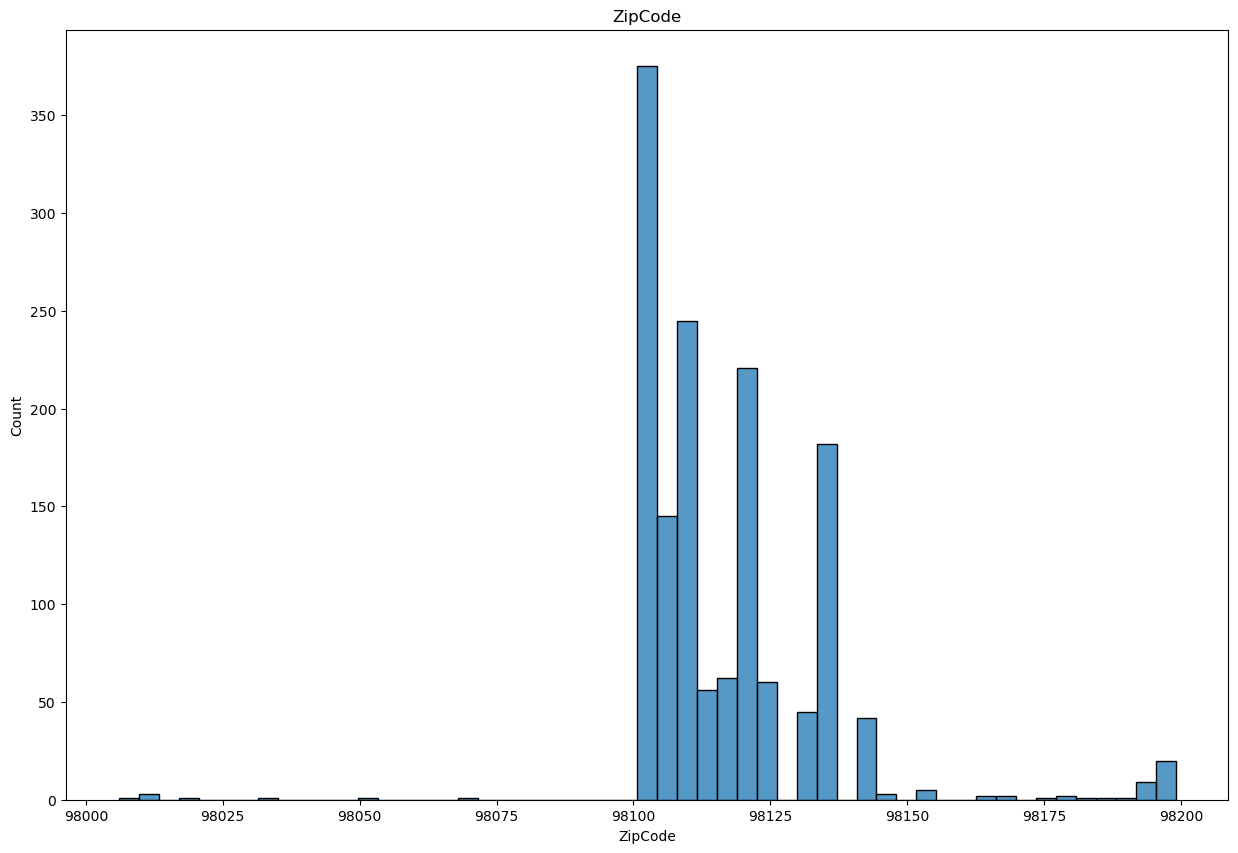

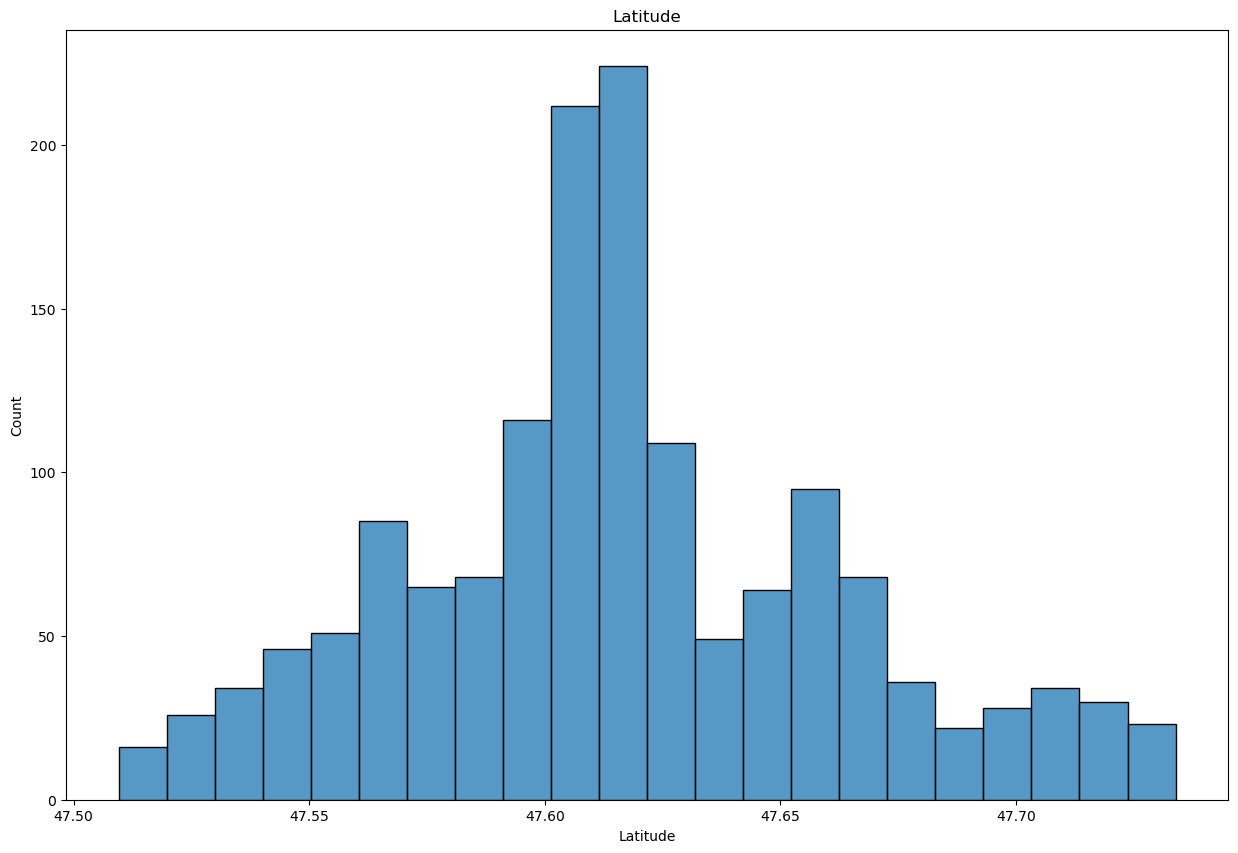

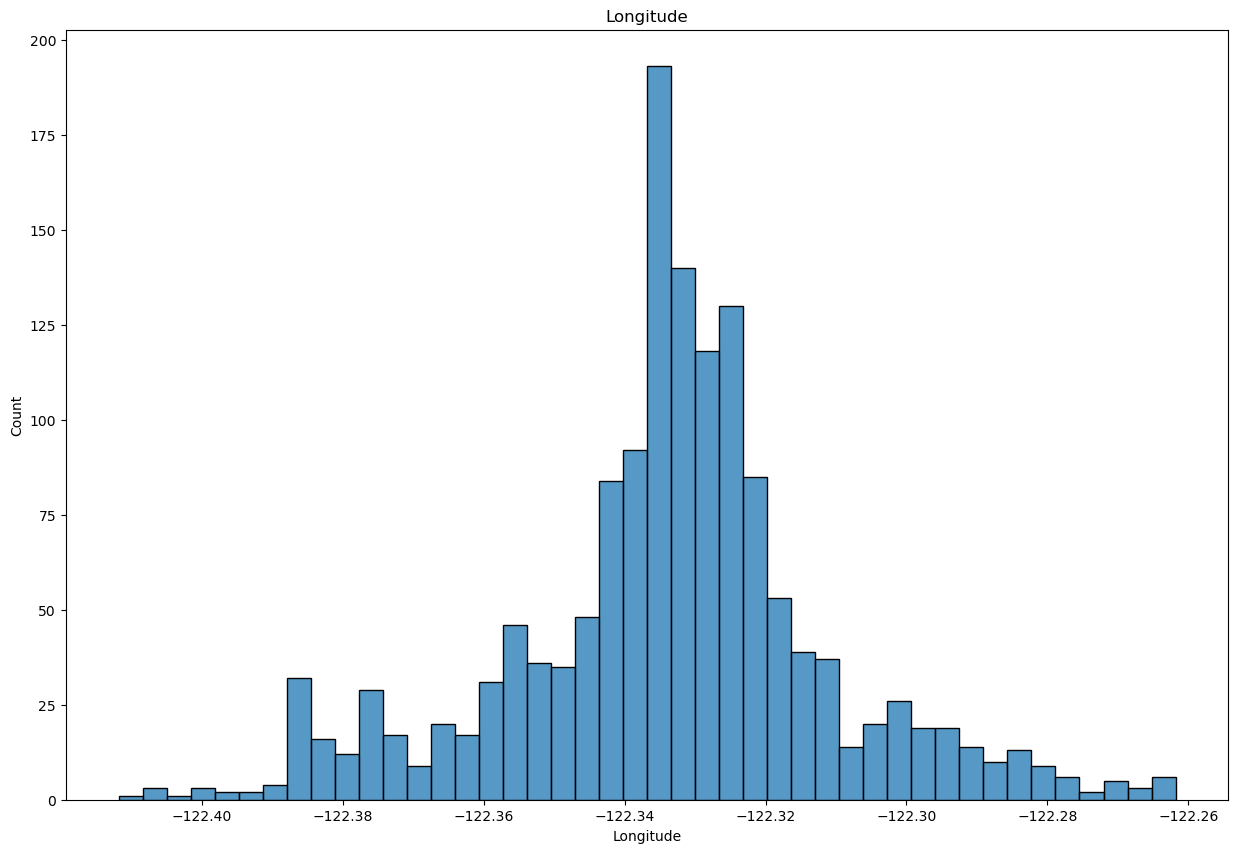

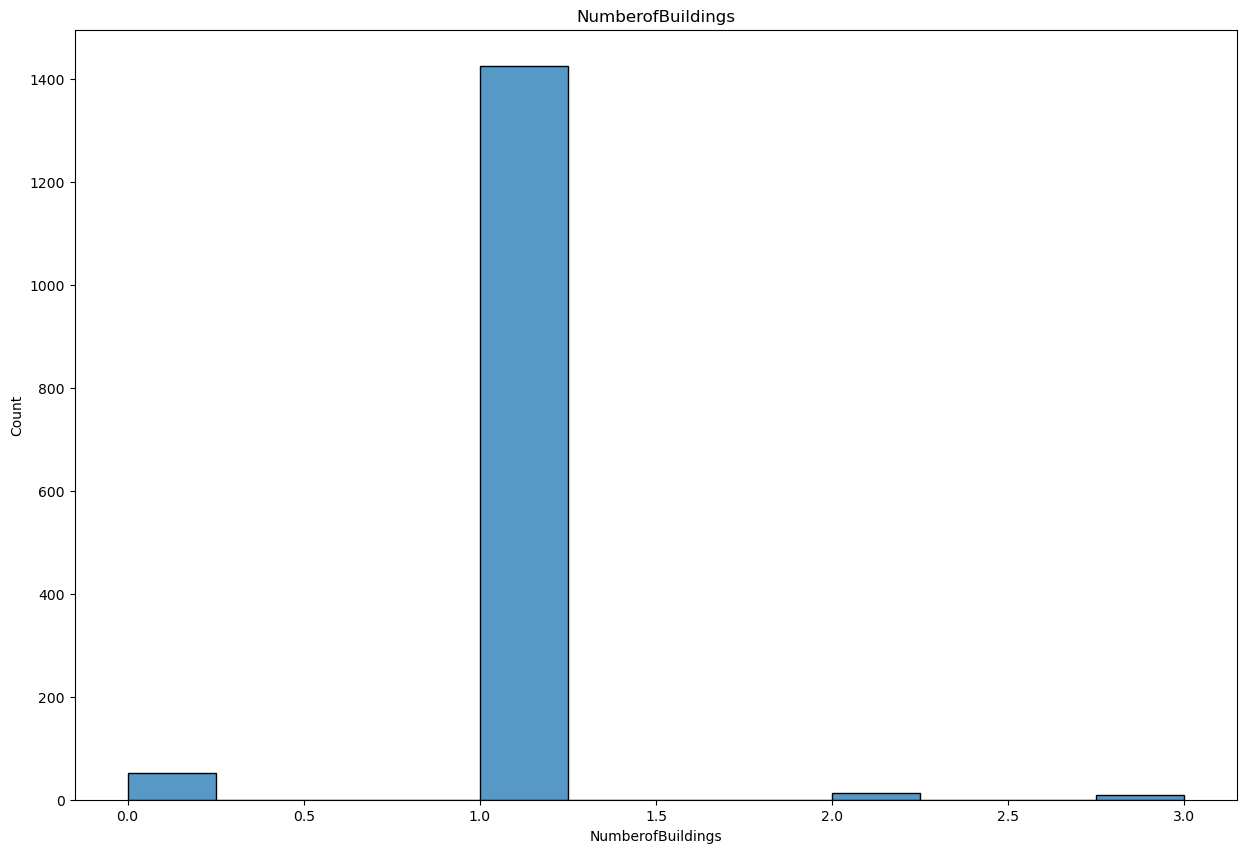

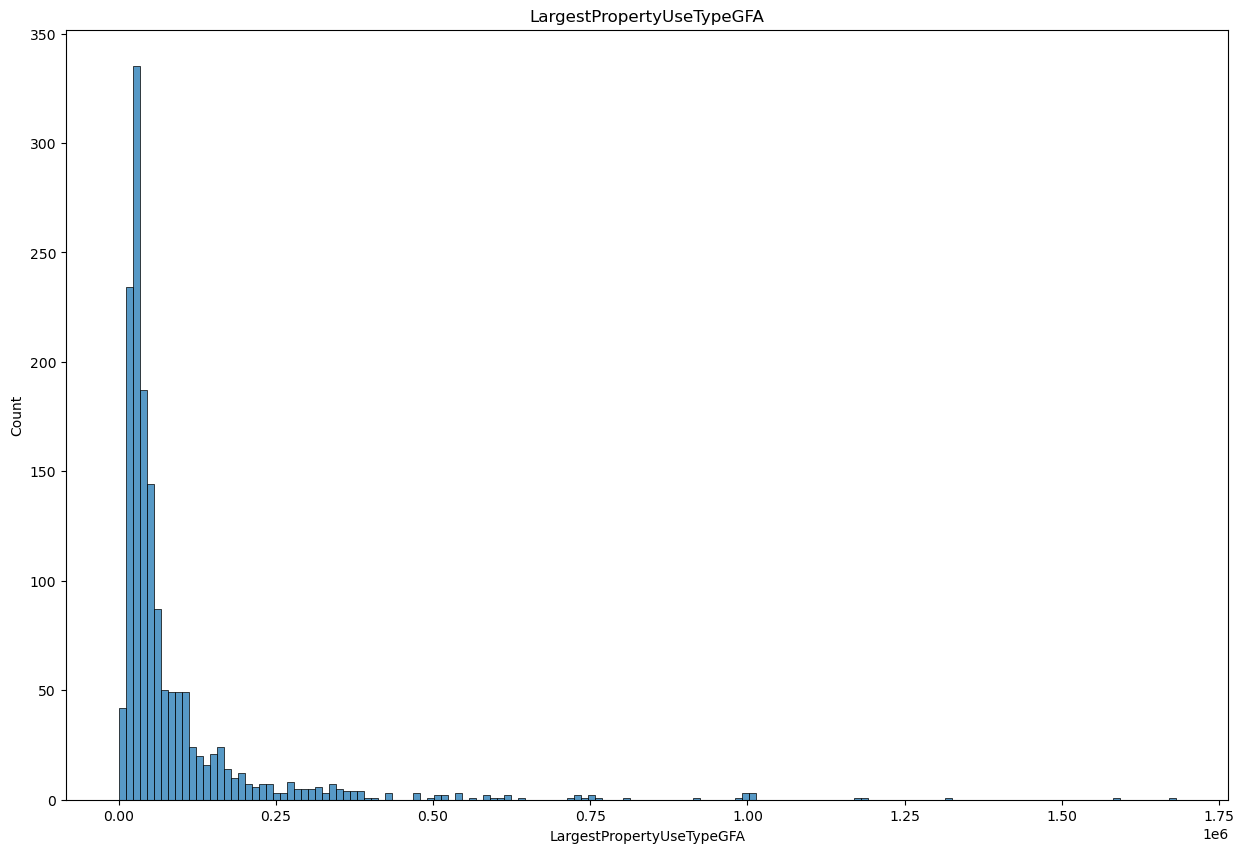

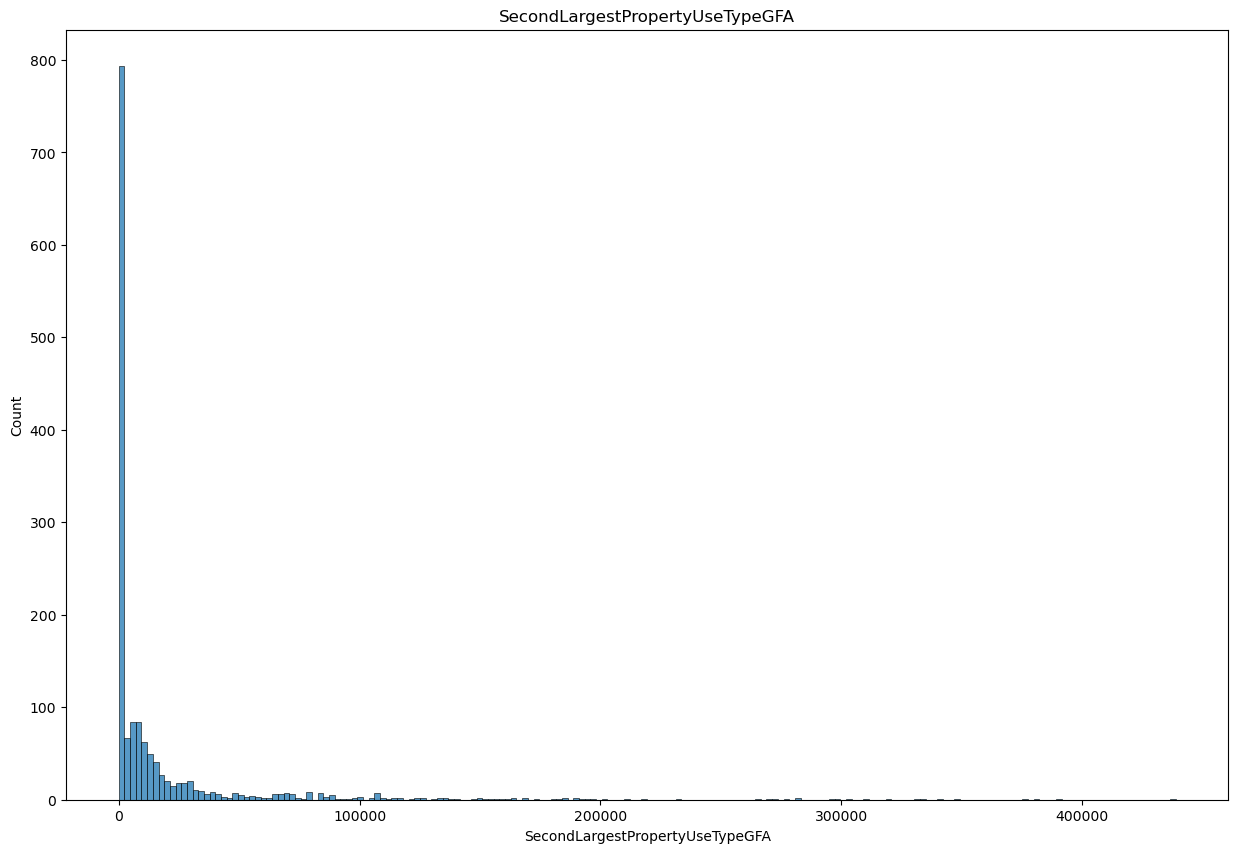

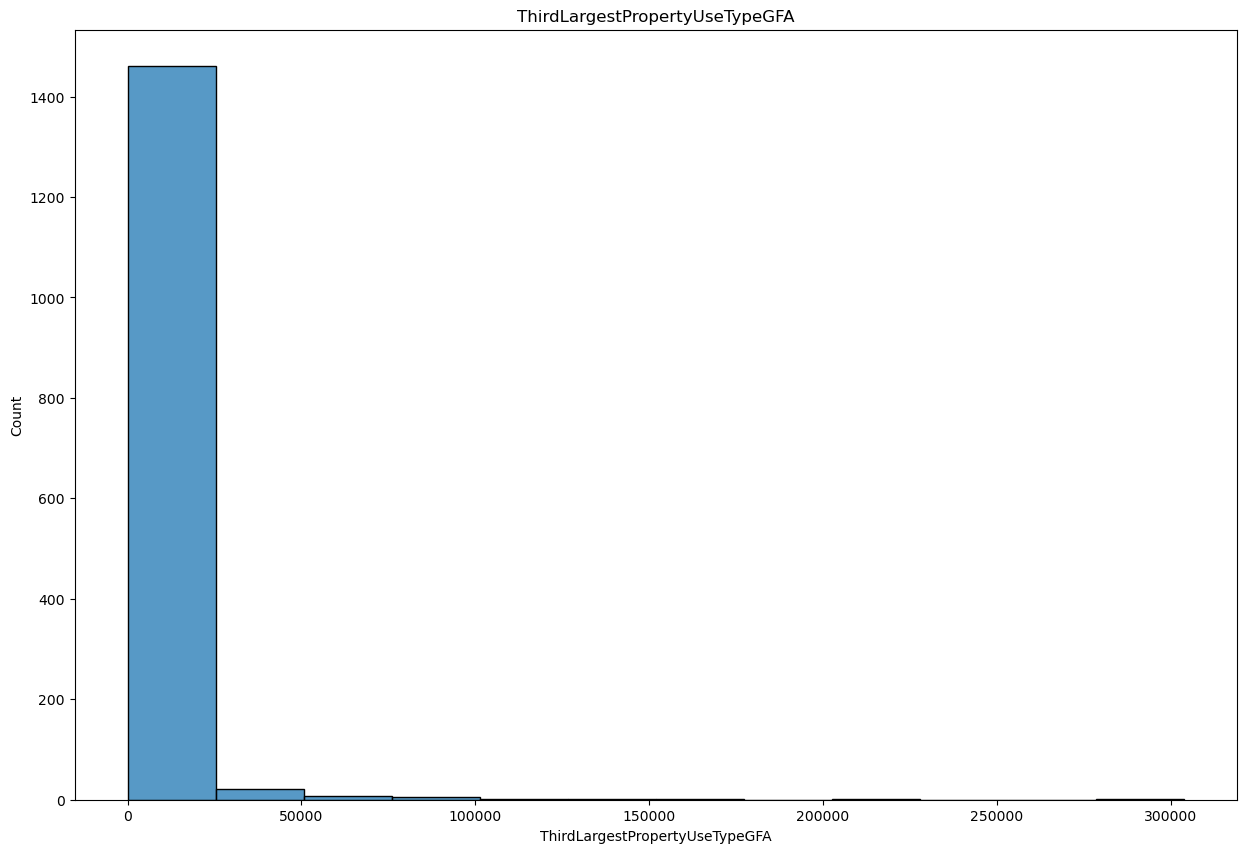

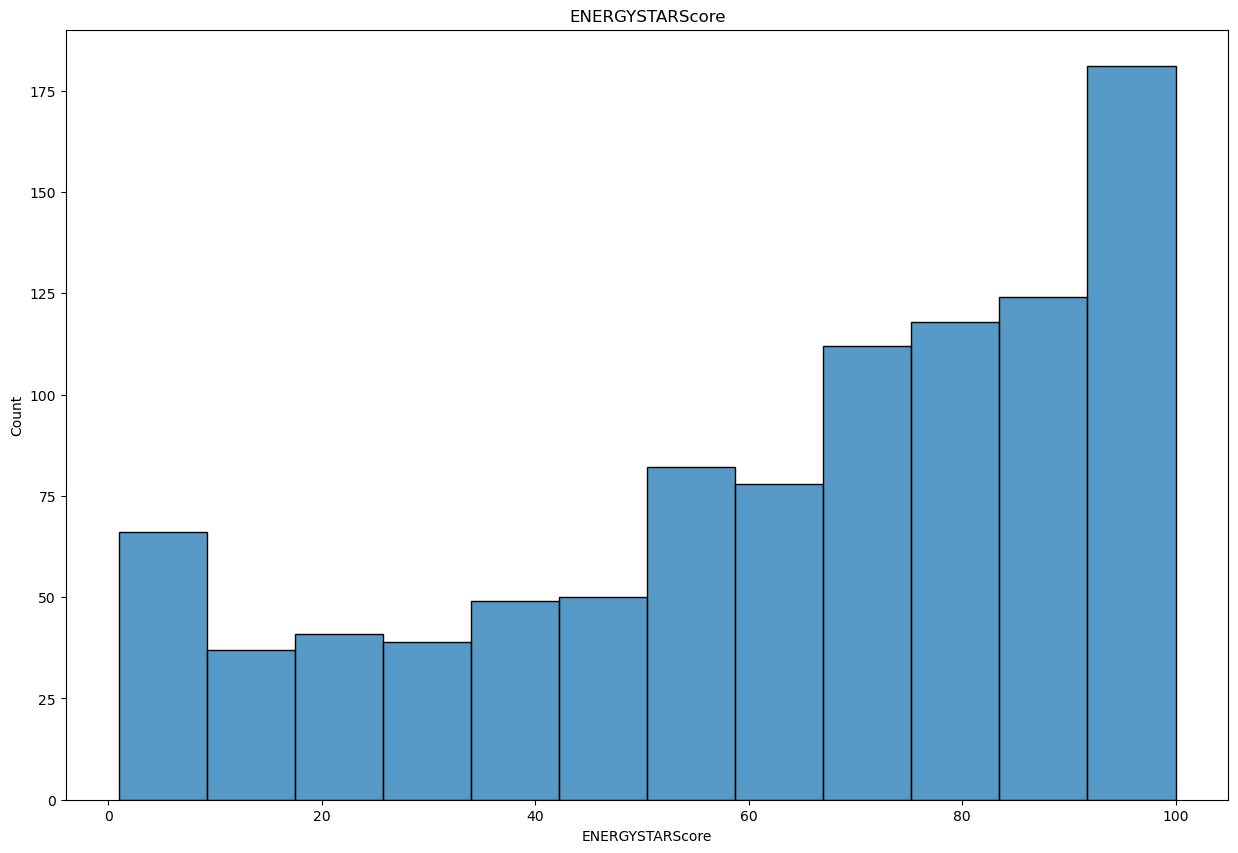

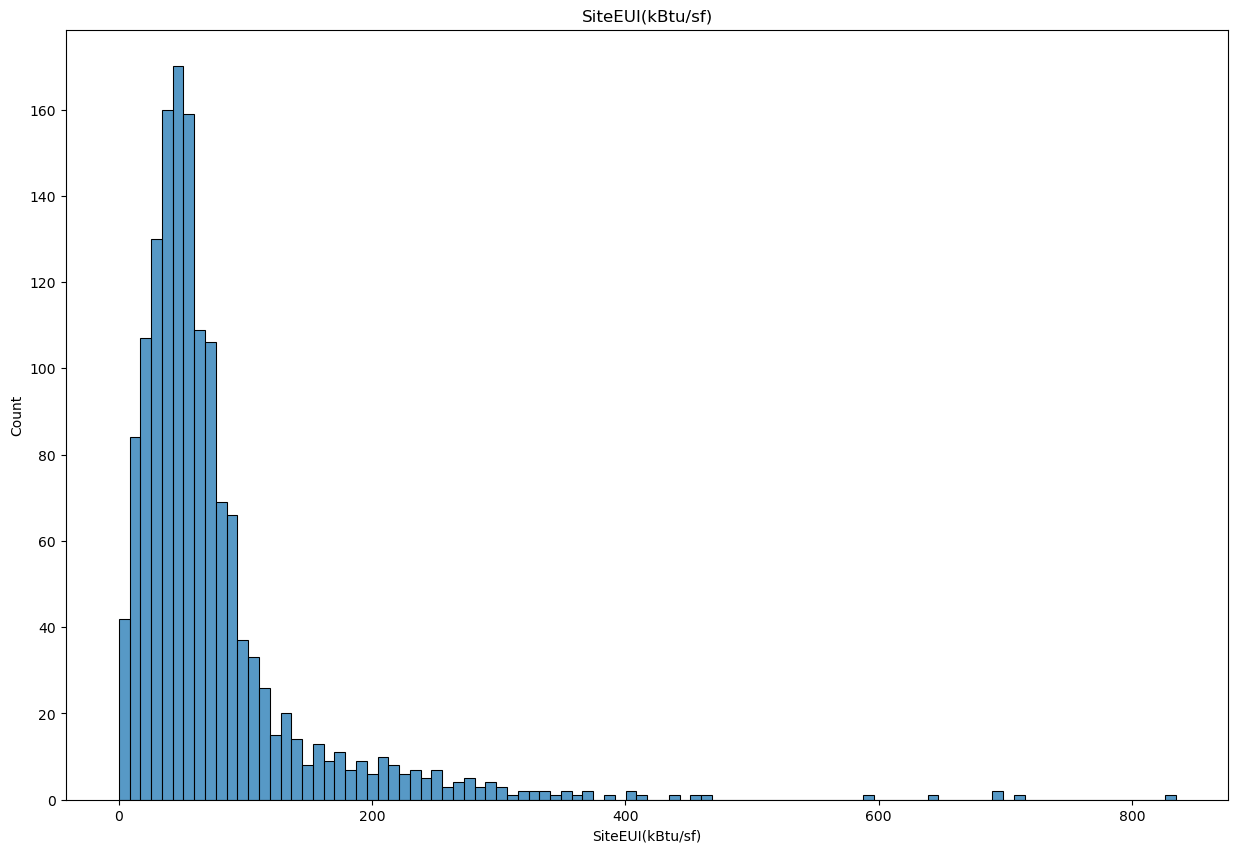

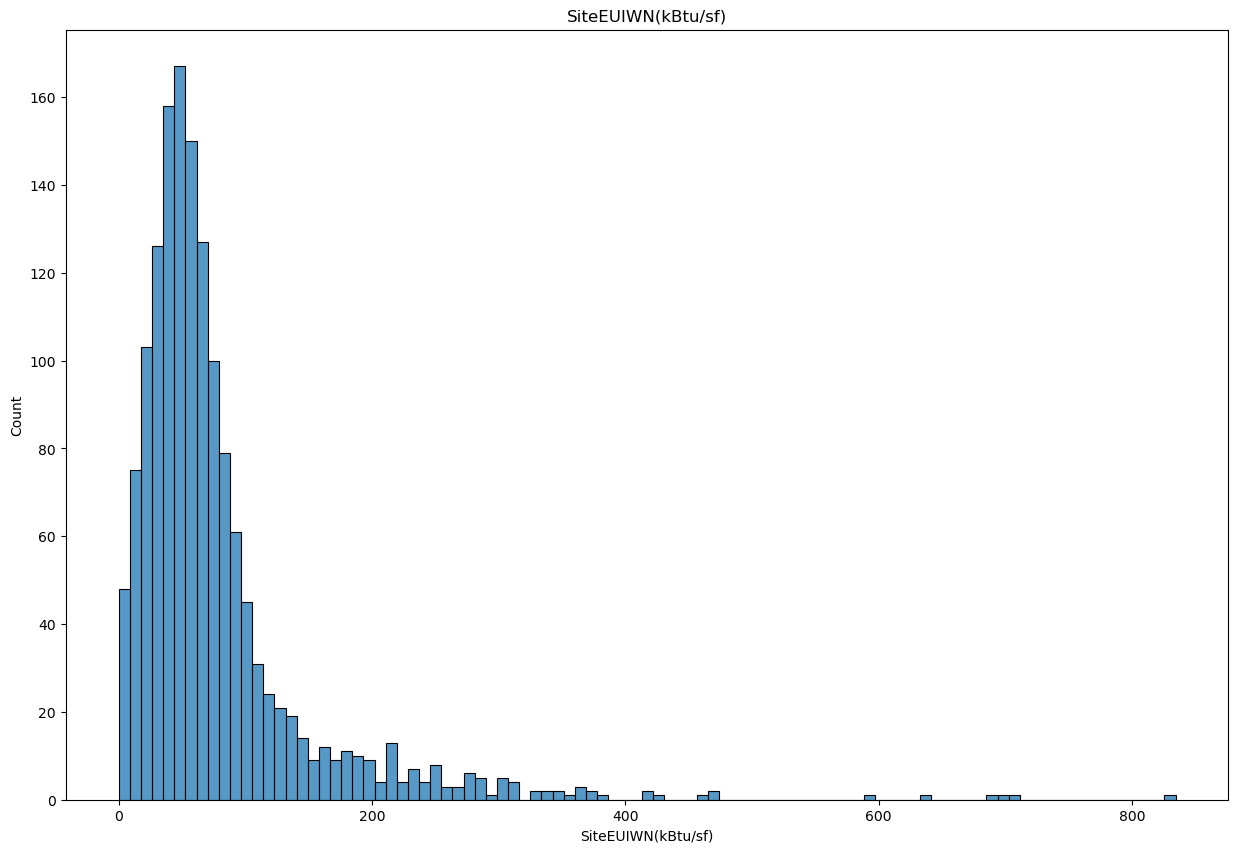

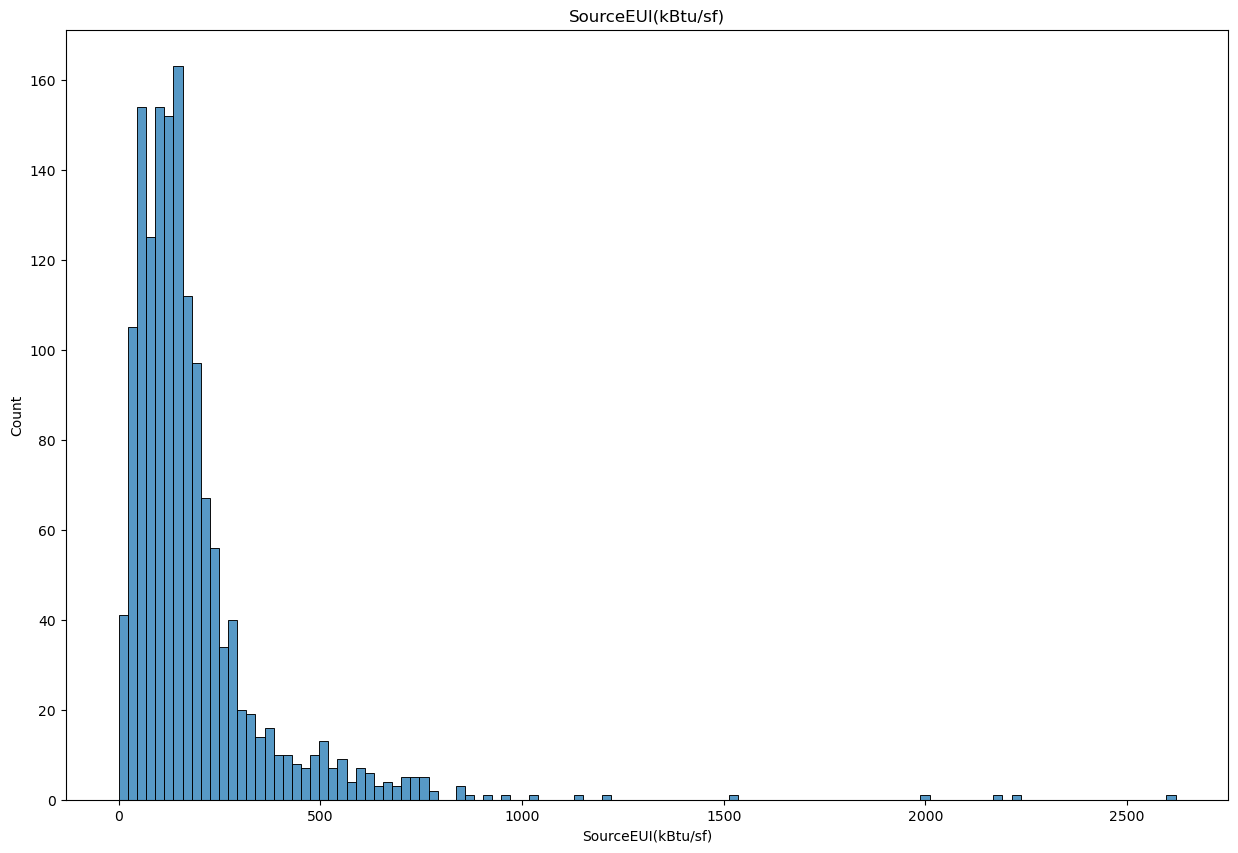

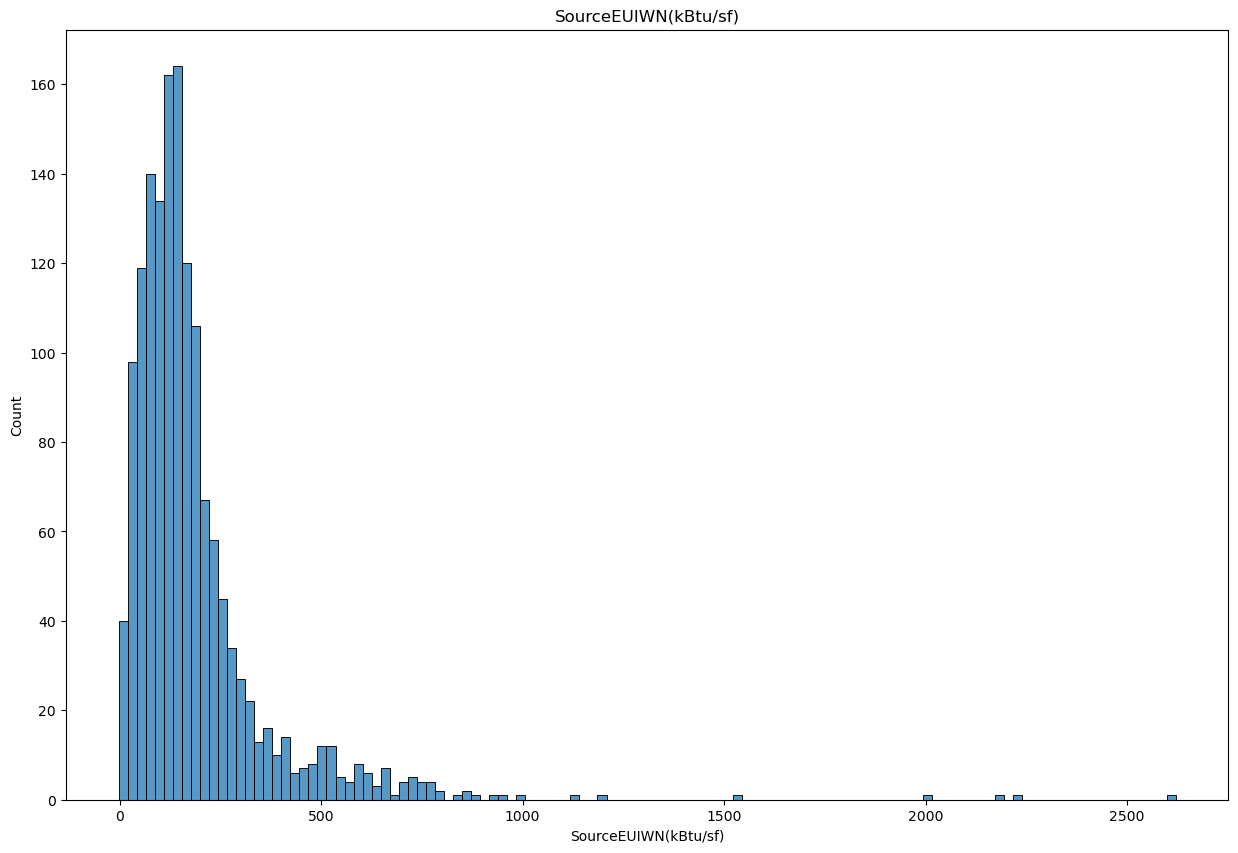

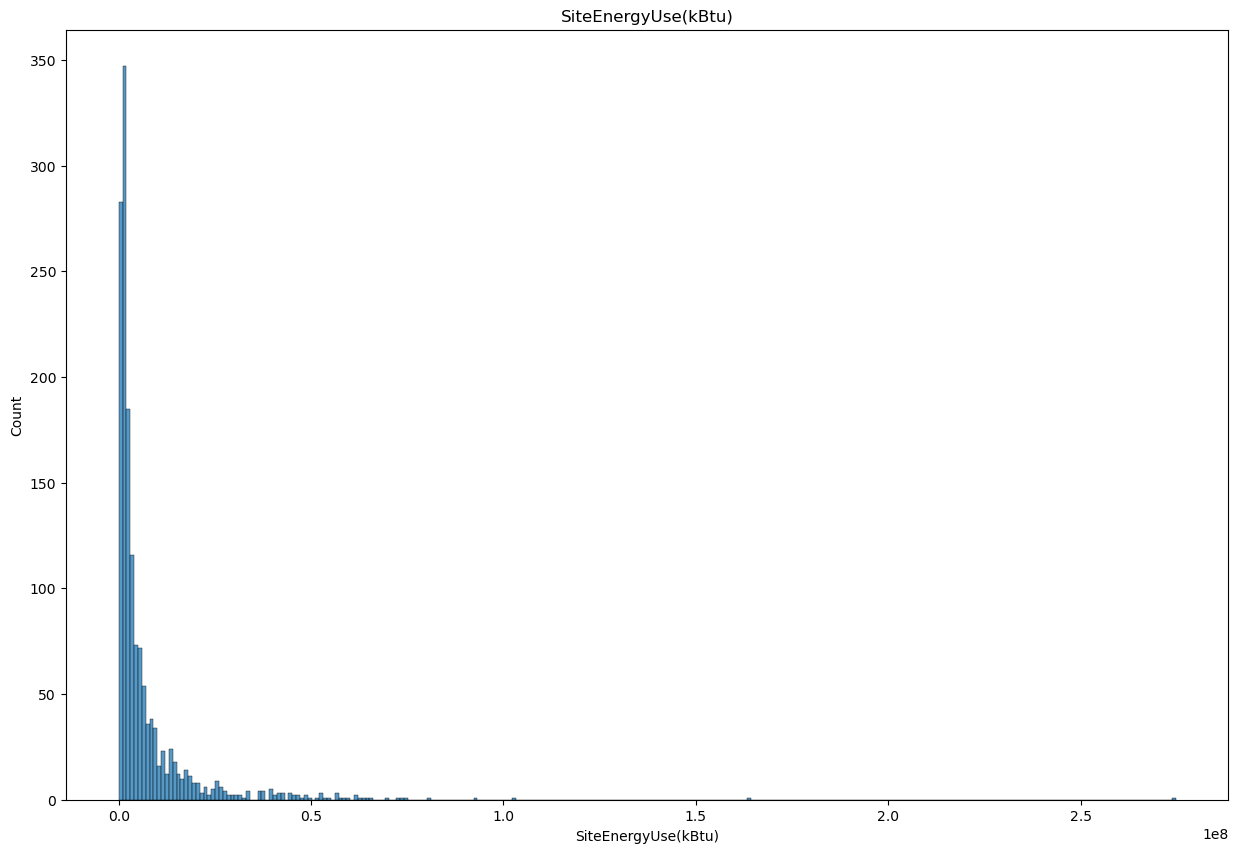

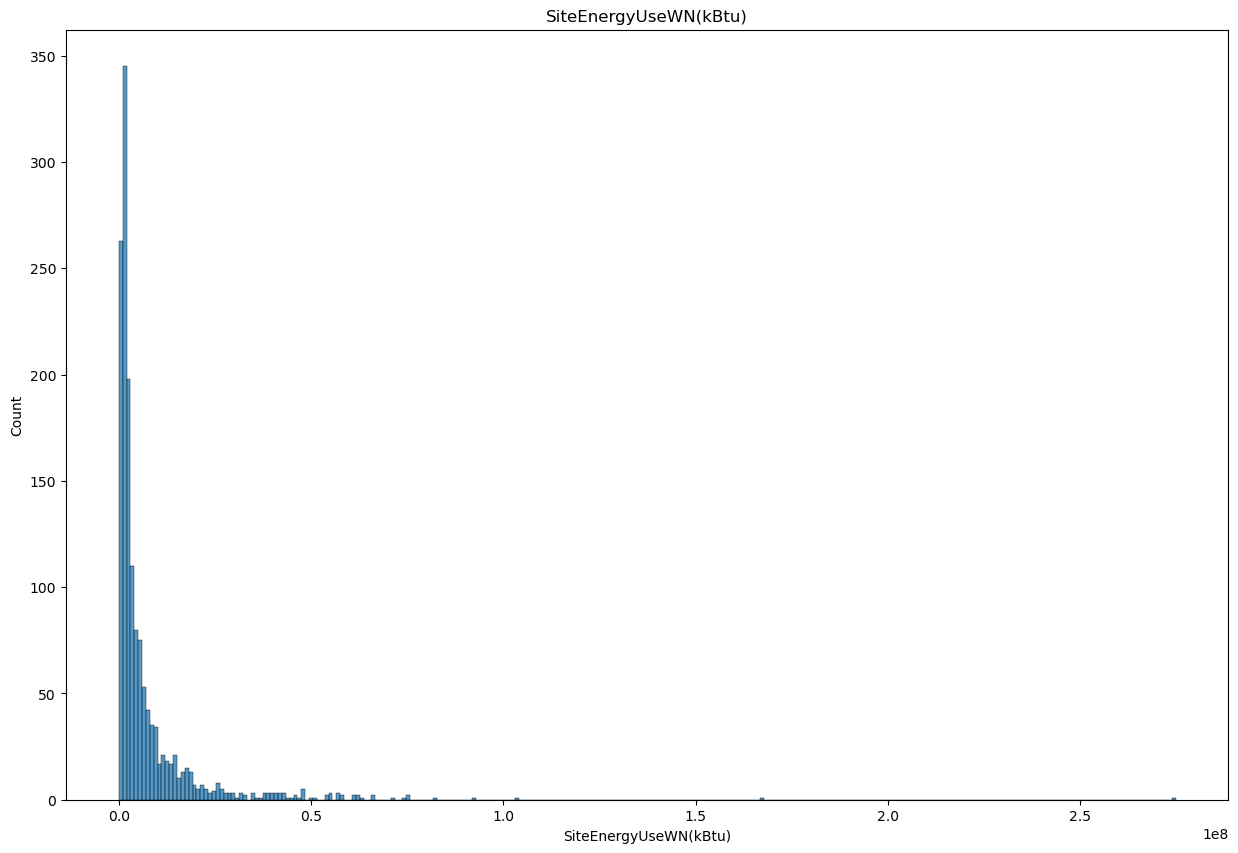

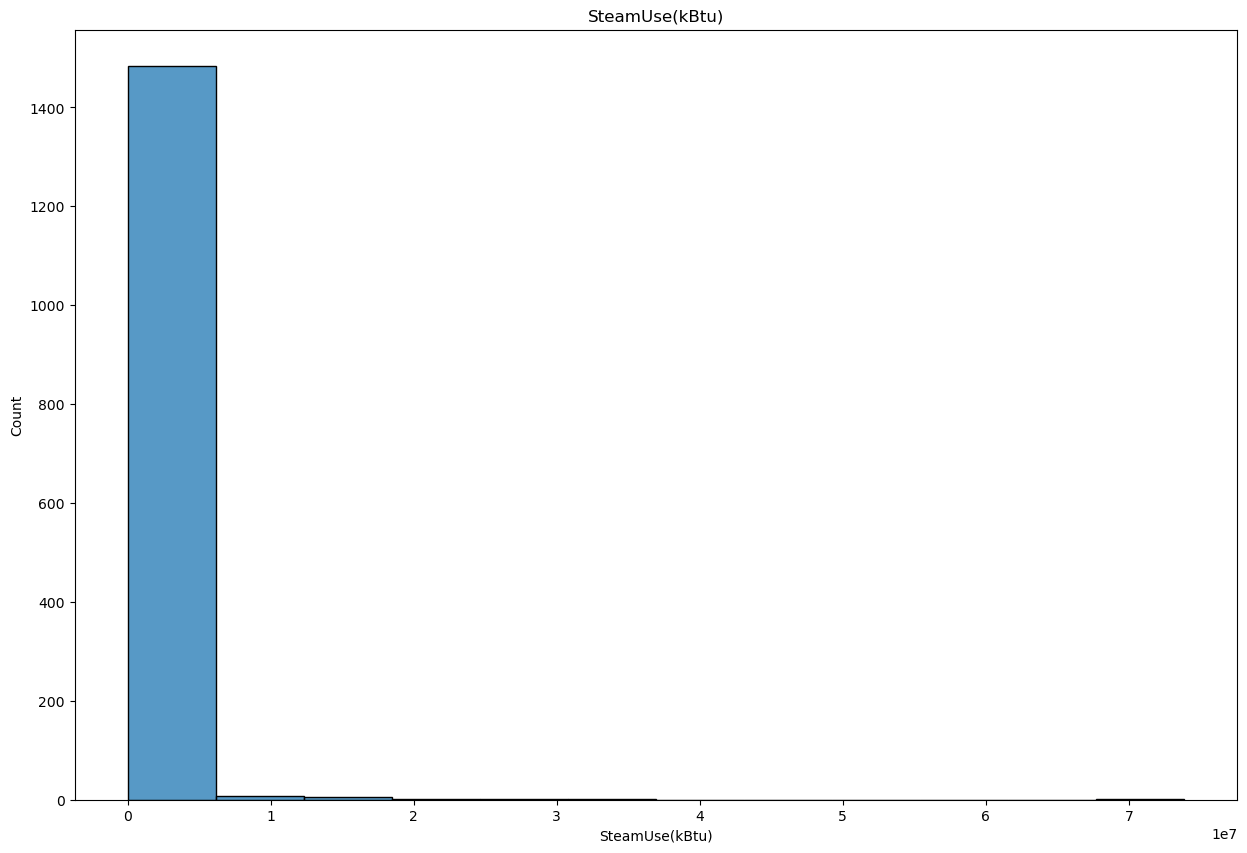

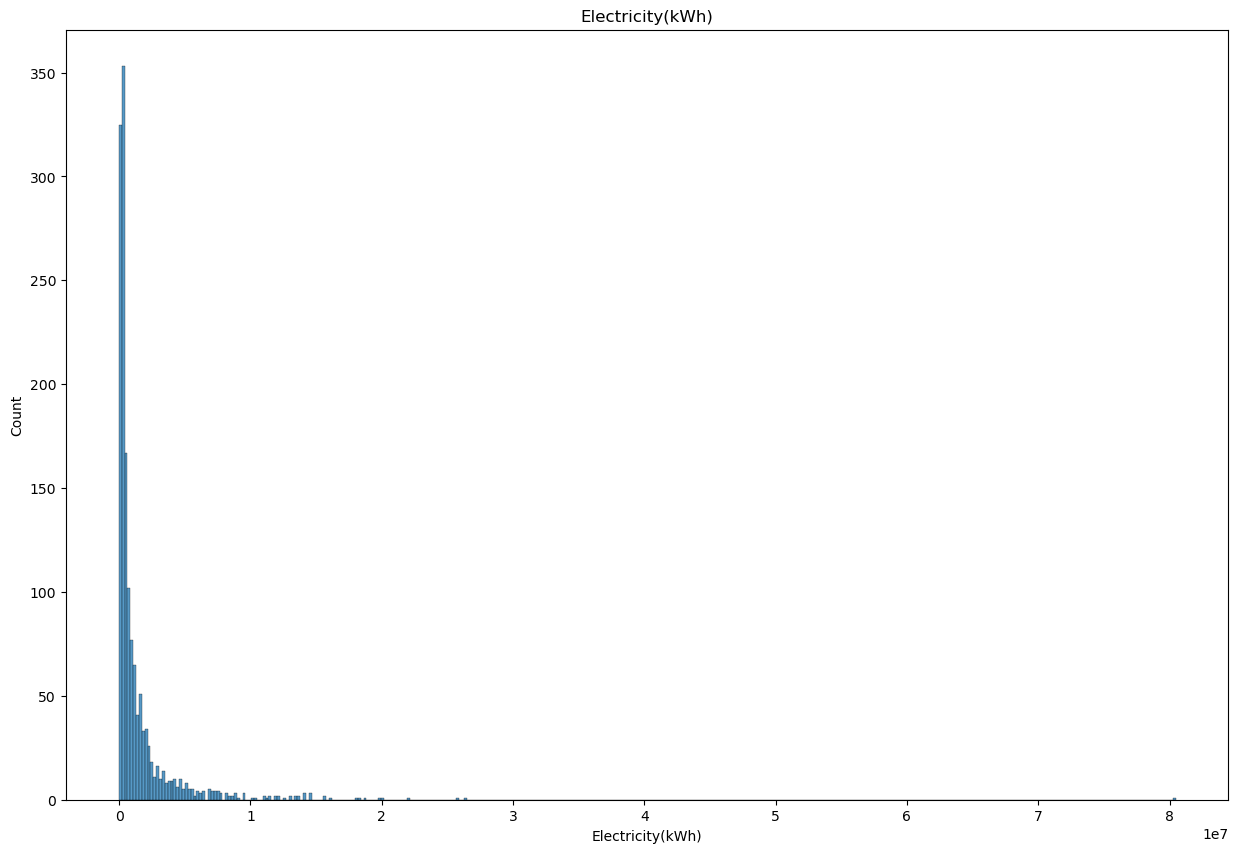

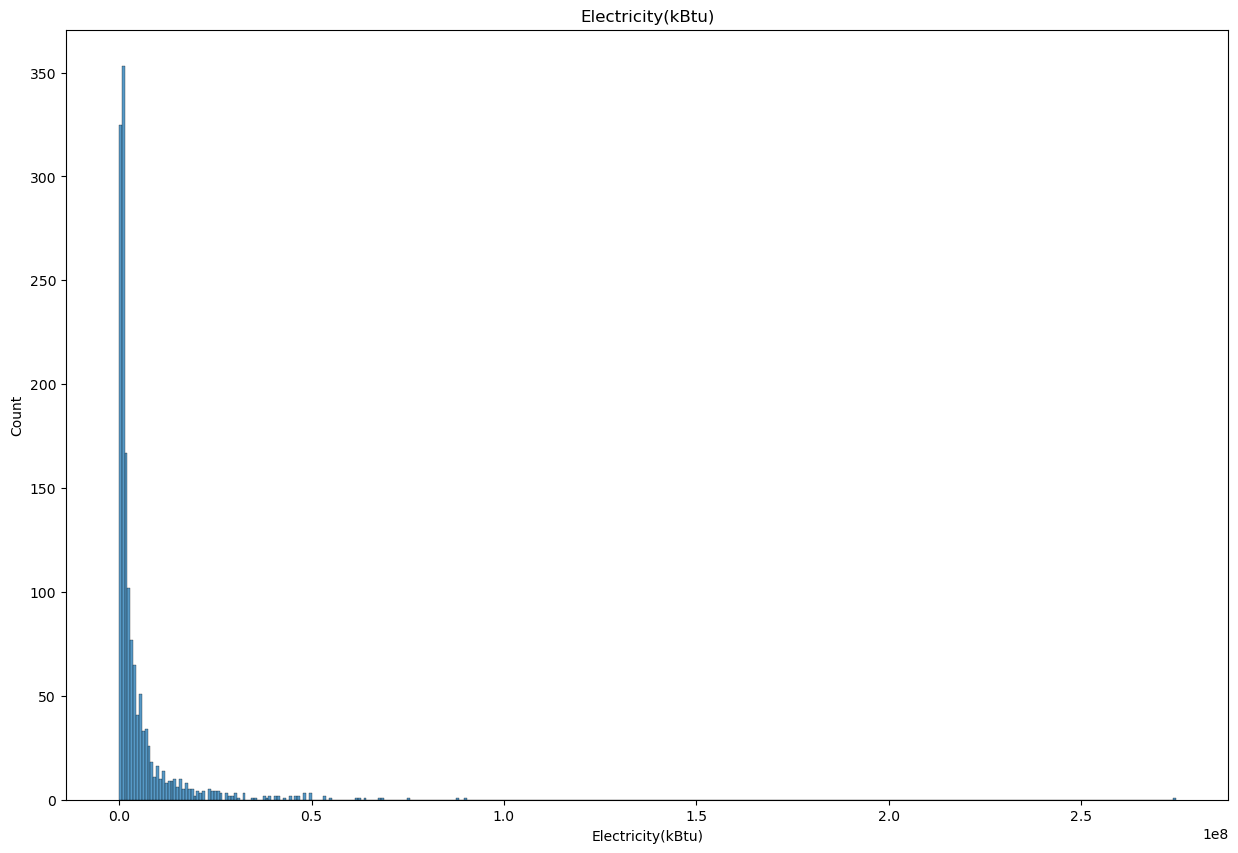

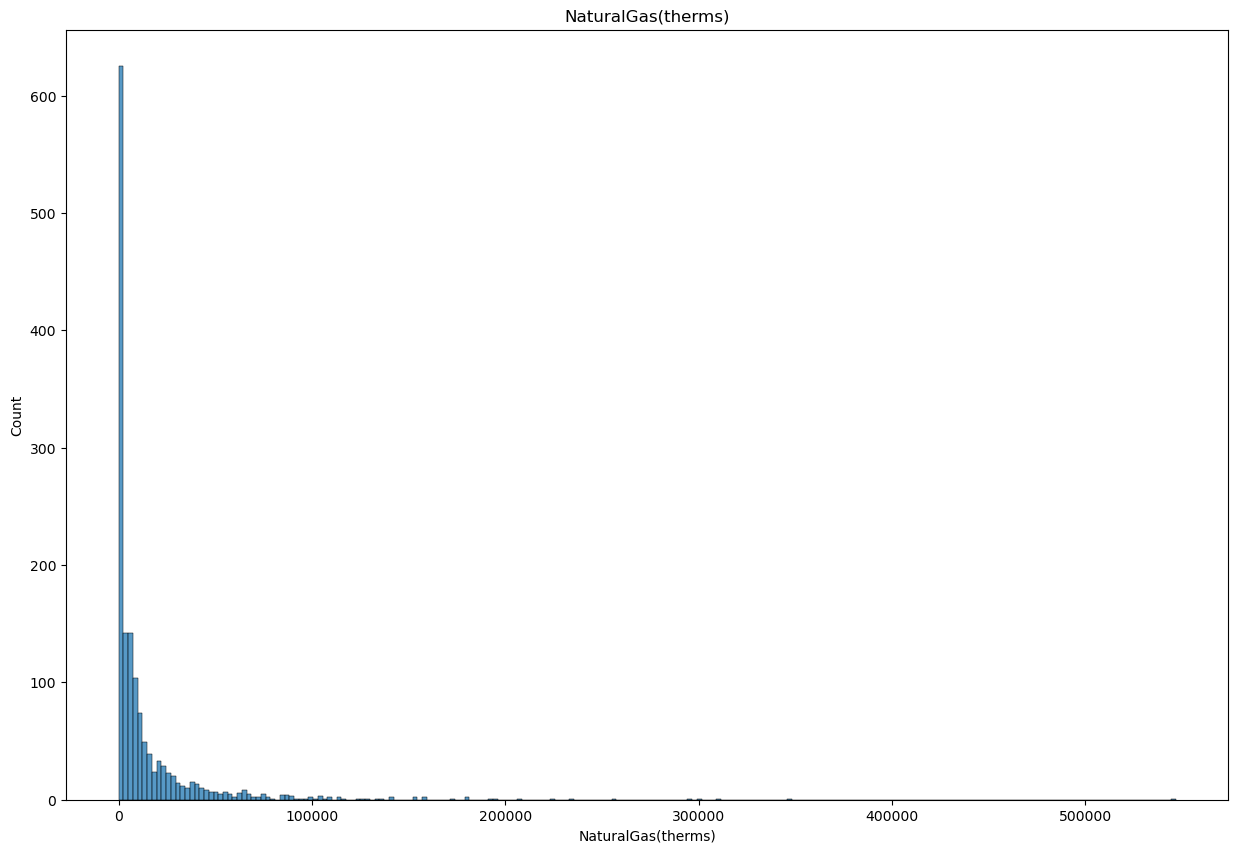

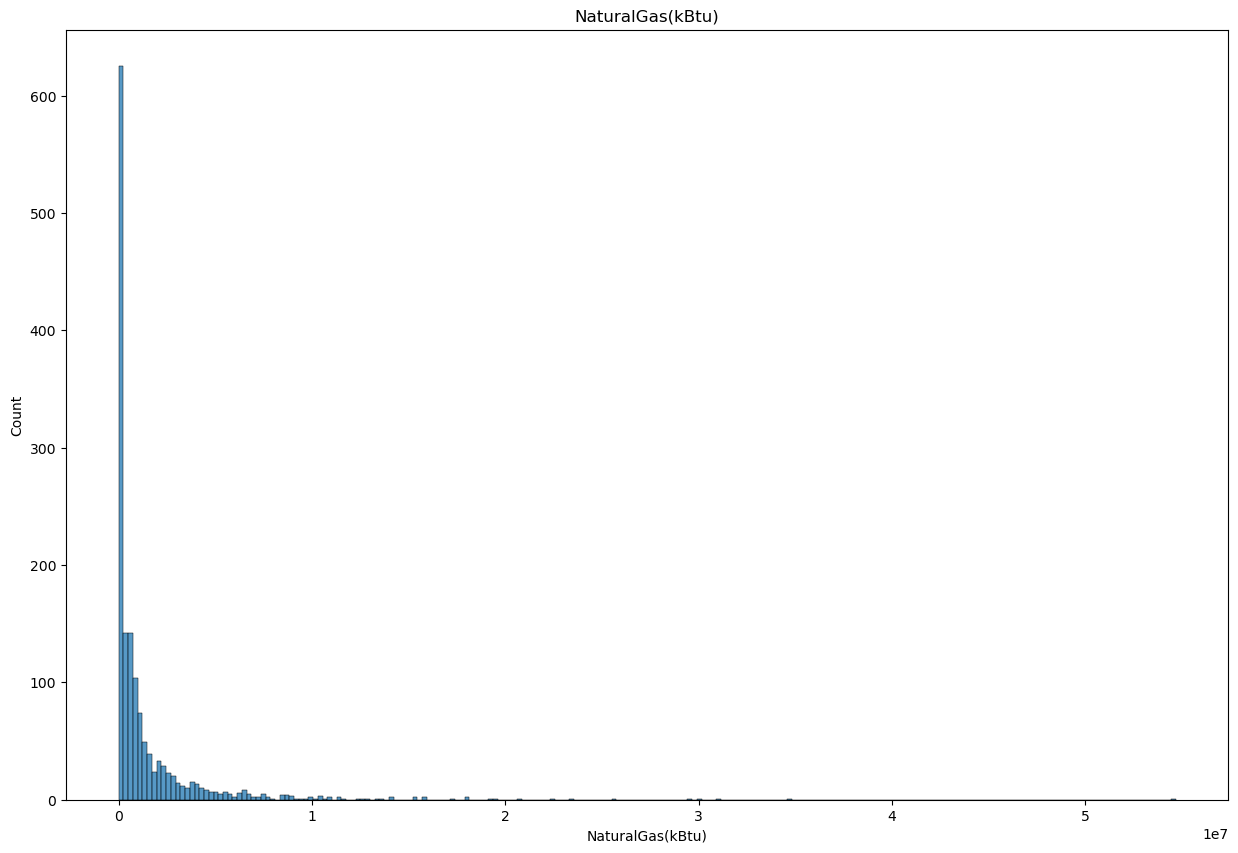

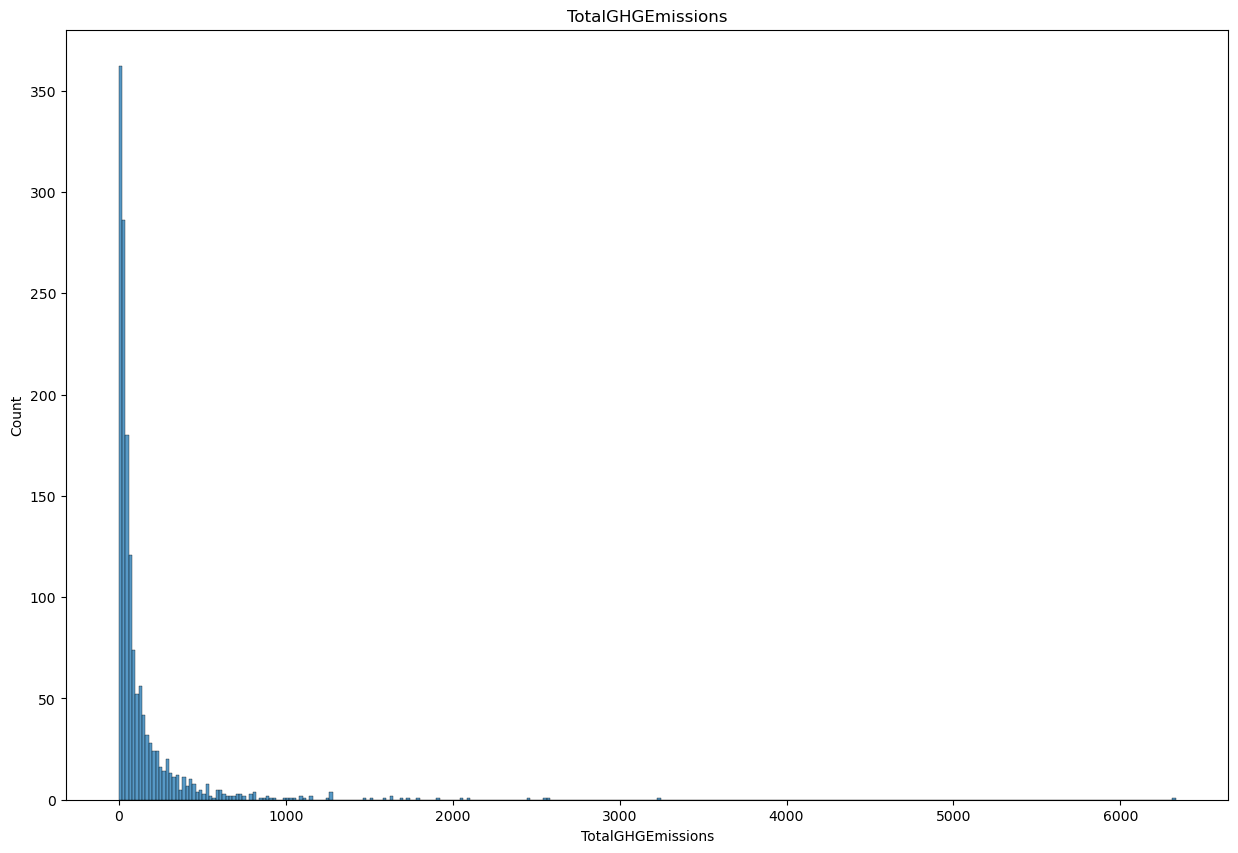

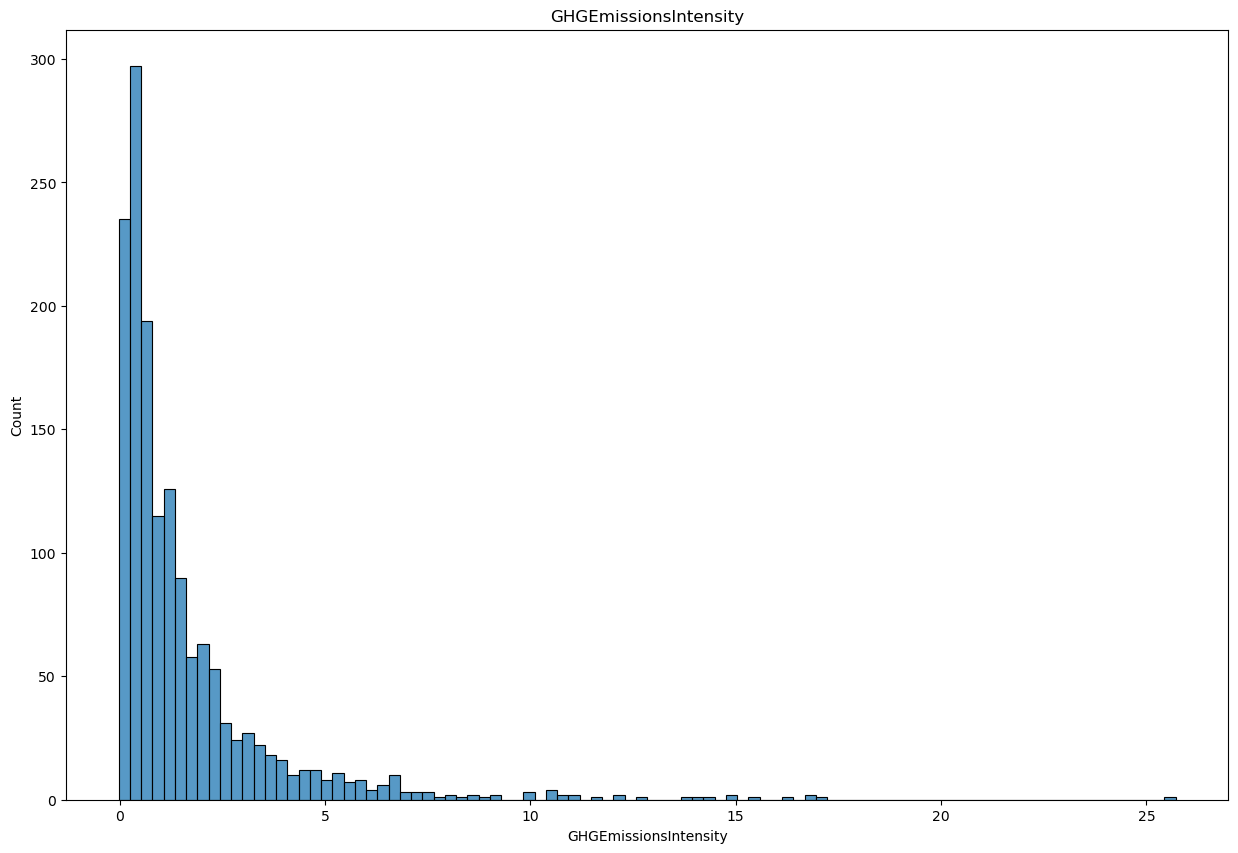

In [53]:
for col in data.select_dtypes('float'):
    plt.figure(figsize=(15, 10))
    sns.histplot(data[col])
    plt.title(col)
    plt.show()

**NOMBRE DE BÂTIMENTS =0**

On va vérifier que toutes les lignes aient au minimum 1 bâtiment dans la variable 'NumberofBuildings'. On supprimera au besoin ses lignes.

In [54]:
display(data[data['NumberofBuildings']==0].head())

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
63              89      2016  NonResidential               Medical Office   
76             113      2016  NonResidential  Small- and Mid-Sized Office   
160            257      2016  NonResidential                    Warehouse   
201            322      2016  NonResidential                 Large Office   
241            366      2016  NonResidential  Small- and Mid-Sized Office   

                              PropertyName           Address     City State  \
63               Polyclinic North && South  1200 Harvard Ave  Seattle    WA   
76                                   KCTS9     401 Mercer St  Seattle    WA   
160  Harbor Island: Warehouse E - DNRP-SWD  3235 16TH AVE SW  Seattle    WA   
201  Cox Media Group Seattle KIRO TV (322)      2801 3rd Ave  Seattle    WA   
241     University District Office Buiding   1107 NE 45th St  Seattle    WA   

     ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
63   98122.0                    1978201270                    3   
76   98109.0                    1988200705                    7   
160  98134.0                    7666703020                    1   
201  98121.0                    0656000005                    7   
241  98105.0                    1142000500                    4   

              Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
63                    East  47.61244 -122.32140       1965                0.0   
76   Magnolia / Queen Anne  47.62391 -122.34837       1986                0.0   
160       Greater Duwamish  47.57507 -122.35747       1916                0.0   
201               Downtown  47.61757 -122.35122       1968                0.0   
241              Northeast  47.66100 -122.31626       1961                0.0   

     NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
63                3            179014                   0   
76                2             66240                2352   
160               4             79600                   0   
201               3            100734               26731   
241               5             99005                   0   

     PropertyGFABuilding(s)  \
63                   179014   
76                    63888   
160                   79600   
201                   74003   
241                   99005   

                             ListOfAllPropertyUseTypes  \
63                                      Medical Office   
76   Data Center, Distribution Center, Office, Park...   
160                         Non-Refrigerated Warehouse   
201                                             Office   
241                                             Office   

         LargestPropertyUseType  LargestPropertyUseTypeGFA  \
63               Medical Office                   179014.0   
76                       Office                    45900.0   
160  Non-Refrigerated Warehouse                    79600.0   
201                      Office                   100734.0   
241                      Office                    79555.0   

    SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
63                          None                              0.0   
76                   Data Center                           5181.0   
160                         None                              0.0   
201                         None                              0.0   
241                         None                              0.0   

    ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
63                         None                             0.0   
76          Distribution Center                          4551.0   
160                        None                             0.0   
201                        None                             0.0   
241                        None                             0.0   

    YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
63              

In [55]:
index_drop = (data[data['NumberofBuildings']==0]).index
print(index_drop)

Int64Index([  63,   76,  160,  201,  241,  264,  278,  280,  291,  358,  365,
             417,  429,  433,  477,  481,  488,  494,  544,  608,  809,  952,
             985, 1002, 1025, 1177, 1244, 1256, 1317, 1606, 2054, 2115, 2166,
            2188, 2214, 2382, 2407, 2441, 2482, 2564, 2631, 2708, 2715, 2747,
            2782, 2963, 3108, 3121, 3155, 3205, 3232, 3259],
           dtype='int64')


In [56]:
data = data.drop(index_drop, axis=0)

print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1449


**ANALYSE**

On peut voir que pour nos 2 variables cibles, elle ne sont pas standardisées et sont plutôt asymétriques.
Elles ont un haut pic proche de 0 et décroient très rapidement. Elles sont très concentrées et n'ont que quelques valeurs hors de cette concentration.

## Variables structurelles

Regardons comment sont structurés les bâtiments.

**SYNTHESE**

Il y a 8 types de batiments qui se situe à Washington dans la ville de Seattle. 

Sur 3376 batiments nous avons 3354 adresses différentes.

Puis nous avons plusieurs variables qui nous donnes des informations sur la propriété en elle même(type..)

In [57]:
display(data.describe(include=[object]))

BuildingType          PrimaryPropertyType      PropertyName  \
count             1449                         1449              1449   
unique               3                           21              1446   
top     NonResidential  Small- and Mid-Sized Office  Bayview Building   
freq              1376                          275                 2   

                            Address     City State  \
count                          1449     1449  1449   
unique                         1429        1     1   
top     309 South Cloverdale Street  Seattle    WA   
freq                              4     1449  1449   

       TaxParcelIdentificationNumber Neighborhood ListOfAllPropertyUseTypes  \
count                           1449         1449                      1449   
unique                          1376           13                       345   
top                       1625049001     Downtown                    Office   
freq                               7          331                       128   

       LargestPropertyUseType SecondLargestPropertyUseType  \
count                    1449                         1449   
unique                     54                           48   
top                    Office                         None   
freq                      466                          659   

       ThirdLargestPropertyUseType YearsENERGYSTARCertified ComplianceStatus  
count                         1449                       91             1449  
unique                          37                       64                2  
top                           None                     2016        Compliant  
freq                          1131                        5             1448

In [58]:
print("\033[1m" + 'BuildingType' + "\033[0m", data['BuildingType'].unique())
print('---')
print("\033[1m" + 'PrimaryPropertyType' + "\033[0m", data['PrimaryPropertyType'].unique())

BuildingType ['NonResidential' 'Nonresidential COS' 'Nonresidential WA']
---
PrimaryPropertyType ['Hotel' 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'K-12 School' 'Large Office' 'Senior Care Community' 'Retail Store'
 'Residence Hall' 'Distribution Center' 'Worship Facility'
 'Medical Office' 'Supermarket / Grocery Store' 'Laboratory' 'Hospital'
 'Refrigerated Warehouse' 'Restaurant' 'Low-Rise Multifamily']


## Vérification des localisations

In [59]:
data_location_verif = data[['Address', 'City', 'State', 'Latitude','Longitude', 'Neighborhood']]
display(data_location_verif.head())

Address     City State  Latitude  Longitude Neighborhood
0    405 Olive way  Seattle    WA  47.61220 -122.33799     Downtown
1  724 Pine street  Seattle    WA  47.61317 -122.33393     Downtown
2  1900 5th Avenue  Seattle    WA  47.61393 -122.33810     Downtown
3   620 STEWART ST  Seattle    WA  47.61412 -122.33664     Downtown
4    401 LENORA ST  Seattle    WA  47.61375 -122.34047     Downtown

In [60]:
# Vérifier les coordonnées
def verify_coordinates(row):
    
    address = f"{row['Address']}, {row['City']}, {row['State']}"
    geolocator = Nominatim(user_agent="my_geocoder")
    geolocator.geocode(address, timeout=10)
    location = geolocator.geocode(address)
    
    if location is not None:
        # Formater les coordonnées avec une précision de 5 chiffres après la virgule
        latitude = round(location.latitude, 5)
        longitude = round(location.longitude, 5)
        return (latitude, longitude)
    else:
        return np.NaN
    
# Fonction pour calculer la différence entre les coordonnées
def calculate_difference(row):
    verified_coordinates = verify_coordinates(row)
    if verified_coordinates is not None:
        diff_longitude = verified_coordinates[1] - row['Longitude']
        diff_latitude = verified_coordinates[0] - row['Latitude']
        return pd.Series({'Latitude_err': diff_latitude, 'Longitude_err': diff_longitude})
    else:
        return pd.Series({'Latitude_err': None, 'Longitude_err': None})

In [61]:
def lexical_adress(data, column_name):
    # Normaliser la colonne spécifiée
    data[column_name] = data[column_name].str.title()
    data[column_name] = data[column_name].str.replace('Jeffrson', 'Jefferson ')
    data[column_name] = data[column_name].str.replace('Mlk', 'Martin Luther King ')

In [62]:
lexical_adress(data, 'Address')
lexical_adress(data_location_verif, 'Address')

/var/folders/sg/93kbc44x3dz8s65w44mhwm100000gn/T/ipykernel_86323/3858963446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].str.title()
/var/folders/sg/93kbc44x3dz8s65w44mhwm100000gn/T/ipykernel_86323/3858963446.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].str.replace('Jeffrson', 'Jefferson ')
/var/folders/sg/93kbc44x3dz8s65w44mhwm100000gn/T/ipykernel_86323/3858963446.py:5: SettingWithCopyWarning: 
A value is trying to be

In [63]:
# Visualisation sur un quartier
data_location_verif = data_location_verif[data_location_verif['Neighborhood'] == 'Central']
data_location_verif = data_location_verif.head()
display(data_location_verif.head())

Address     City State  Latitude  Longitude Neighborhood
58     1700 E. Cherry St  Seattle    WA  47.60823 -122.30956      Central
117  1211 E Alder Street  Seattle    WA  47.60462 -122.31549      Central
405   1130 Rainier Ave S  Seattle    WA  47.59367 -122.30957      Central
408       1708 E Pike St  Seattle    WA  47.61440 -122.30982      Central
493  1600 E Jefferson St  Seattle    WA  47.60649 -122.31121      Central

In [64]:
data_location_verif = data_location_verif.assign(Verified_Coordinates=data_location_verif.apply(verify_coordinates, axis=1))

In [65]:
display(data_location_verif.head())

Address     City State  Latitude  Longitude Neighborhood  \
58     1700 E. Cherry St  Seattle    WA  47.60823 -122.30956      Central   
117  1211 E Alder Street  Seattle    WA  47.60462 -122.31549      Central   
405   1130 Rainier Ave S  Seattle    WA  47.59367 -122.30957      Central   
408       1708 E Pike St  Seattle    WA  47.61440 -122.30982      Central   
493  1600 E Jefferson St  Seattle    WA  47.60649 -122.31121      Central   

       Verified_Coordinates  
58   (47.60823, -122.30956)  
117   (47.6048, -122.31559)  
405  (47.59285, -122.30881)  
408    (47.6145, -122.3098)  
493    (47.60655, -122.311)

In [66]:
# Distance_err
data_location_verif['Distance_err_km'] = data_location_verif.apply(
    lambda row: round(geodesic((row['Latitude'], row['Longitude']), row['Verified_Coordinates']).km, 3),
    axis=1
)

In [67]:
data_location_verif.head()

Address     City State  Latitude  Longitude Neighborhood  \
58     1700 E. Cherry St  Seattle    WA  47.60823 -122.30956      Central   
117  1211 E Alder Street  Seattle    WA  47.60462 -122.31549      Central   
405   1130 Rainier Ave S  Seattle    WA  47.59367 -122.30957      Central   
408       1708 E Pike St  Seattle    WA  47.61440 -122.30982      Central   
493  1600 E Jefferson St  Seattle    WA  47.60649 -122.31121      Central   

       Verified_Coordinates  Distance_err_km  
58   (47.60823, -122.30956)            0.000  
117   (47.6048, -122.31559)            0.021  
405  (47.59285, -122.30881)            0.108  
408    (47.6145, -122.3098)            0.011  
493    (47.60655, -122.311)            0.017

In [68]:
# Comparer les coordonnées vérifiées avec celles du DataFrame
data_location_verif = data_location_verif.assign(Coordinates_Match=data_location_verif.apply(lambda row: abs(row['Distance_err_km']) < 0.05, axis=1))

In [69]:
data_location_verif[data_location_verif['Coordinates_Match'] == False]

Address     City State  Latitude  Longitude Neighborhood  \
405  1130 Rainier Ave S  Seattle    WA  47.59367 -122.30957      Central   

       Verified_Coordinates  Distance_err_km  Coordinates_Match  
405  (47.59285, -122.30881)            0.108              False

In [70]:
# Identifier les indices des lignes à supprimer
indices_to_remove = data_location_verif[data_location_verif['Verified_Coordinates'].isnull()].index
display(data_location_verif[data_location_verif['Verified_Coordinates'].isnull()])

# Supprimer les lignes dans data
data = data.drop(indices_to_remove)
data_location_verif = data_location_verif.drop(indices_to_remove)

Empty DataFrame
Columns: [Address, City, State, Latitude, Longitude, Neighborhood, Verified_Coordinates, Distance_err_km, Coordinates_Match]
Index: []

In [71]:
data_location_verif[data_location_verif['Coordinates_Match'] == False]

Address     City State  Latitude  Longitude Neighborhood  \
405  1130 Rainier Ave S  Seattle    WA  47.59367 -122.30957      Central   

       Verified_Coordinates  Distance_err_km  Coordinates_Match  
405  (47.59285, -122.30881)            0.108              False

In [72]:
# Sélection des lignes avec des erreurs 
selected_rows = data_location_verif[
    (data_location_verif['Distance_err_km'] > 0.05)
]
display(selected_rows)

Address     City State  Latitude  Longitude Neighborhood  \
405  1130 Rainier Ave S  Seattle    WA  47.59367 -122.30957      Central   

       Verified_Coordinates  Distance_err_km  Coordinates_Match  
405  (47.59285, -122.30881)            0.108              False

In [73]:
# Créer une carte centrée sur Seattle avec les erreurs
m = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

# Ajouter une couche OpenStreetMap
folium.TileLayer('openstreetmap').add_to(m)

# Ajouter des marqueurs pour chaque adresse dans le sous-ensemble de données
for index, row in selected_rows.iterrows():
    # Marqueur bleu pour l'adresse dans la DataFrame
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Address']}, {row['City']}, {row['State']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

    # Vérifier et ajouter un marqueur orange pour l'adresse comparée
    verified_coordinates = verify_coordinates(row)
    if verified_coordinates is not None:
        folium.Marker(
            location=verified_coordinates,
            popup=f"Verified: {row['Address']}, {row['City']}, {row['State']}, {row['Verified_Coordinates']}",
            icon=folium.Icon(color='orange')
        ).add_to(m)

# Afficher la carte
m

**SYNTHESE**

- Il y a des erreurs lexical dans les adresses, création d'une fonction pour la correction
- Suppression des autres lignes car il y a probablement une erreur dans l'adresse.
- On peut remarquer des erreurs entre les adresses et les latitudes/longitudes. Regardons sur une carte ces erreurs. On prendra les erreurs > 50m
- Ici on a regardé un petit sous échantillon, il pourra être adapté à la base de donnée afin de vérifier les adresses.

## Analyse des correlations

In [74]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

<Axes: >

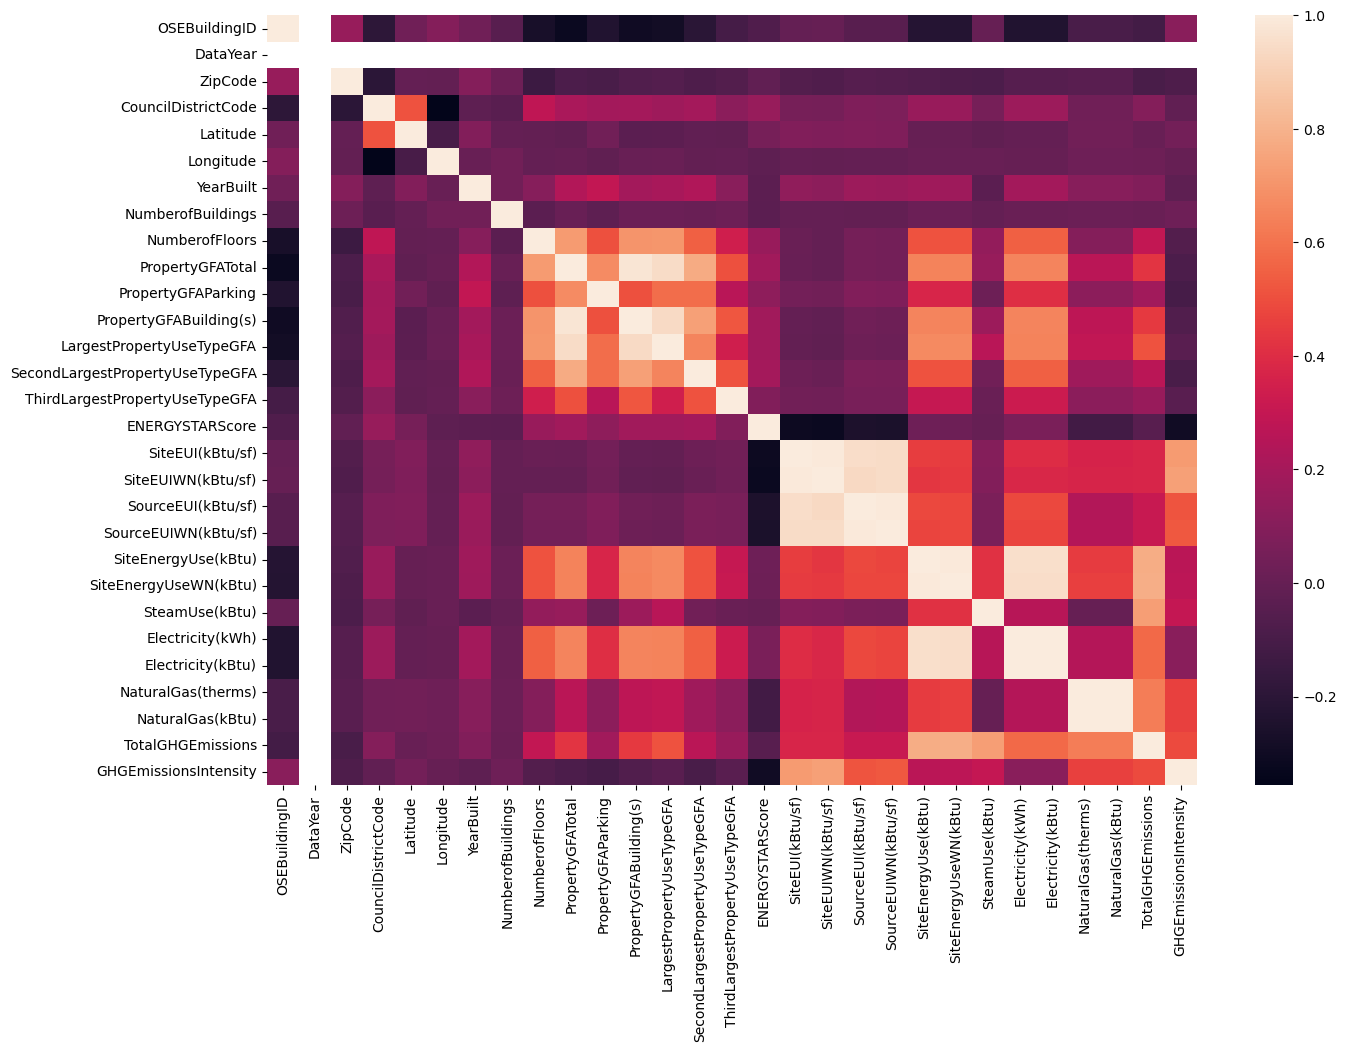

In [75]:
data_correlation = data.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(data_correlation)

**SYNTHESE**

- On peut voir sur la heatmap des sous ensembles corrélés, comme la superficie des batiments et les émissions énergétiques.
- En revanche on remarque un sous ensemble non corrélés : l'Energy star score avec les sites/sources EUI qui correspondent à la consommation annuelle d'énergie.
- On peut voir une corrélation entre 'SiteEnergyUse' et les données énergétiques.

## Valeurs manquantes

In [76]:
data.isnull().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              13
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0


In [77]:
print('Nombre de bâtiment restant :', data.shape[0])

Nombre de bâtiment restant : 1449


In [78]:
data.isnull().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              13
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType          0
SecondLargestPropertyUseTypeGFA       0


In [79]:
zip_code = data[data['ZipCode'].isnull()]
display(zip_code)

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
3360          50196      2016  Nonresidential COS  Mixed Use Property   
3361          50198      2016  Nonresidential COS               Other   
3362          50201      2016  Nonresidential COS               Other   
3363          50204      2016  Nonresidential COS               Other   
3364          50207      2016  Nonresidential COS               Other   
3365          50208      2016  Nonresidential COS               Other   
3367          50212      2016  Nonresidential COS               Other   
3368          50219      2016  Nonresidential COS  Mixed Use Property   
3370          50221      2016  Nonresidential COS               Other   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName                           Address  \
3360           Northgate Community Center                  10510 5Th Ave Ne   
3361                Fire Station 06 (New)  405 Martin Luther King  Jr Way S   
3362                Fire Station 35 (New)                  8729 15Th Ave Nw   
3363                Fire Station 39 (New)                  2806 Ne 127Th St   
3364             Ballard Community Center                  6020 28Th Ave Nw   
3365                         Ballard Pool                   1471 Nw 67Th St   
3367                  Conservatory Campus                   1400 E Galer St   
3368            Garfield Community Center               2323 East Cherry St   
3370          High Point Community Center                  6920 34Th Ave Sw   
3372  International district/Chinatown CC                     719 8Th Ave S   
3373                      Queen Anne Pool                    1920 1St Ave W   
3374          South Park Community Center                    8319 8Th Ave S   
3375          Van Asselt Community Center                  2820 S Myrtle St   

         City State  ZipCode TaxParcelIdentificationNumber  \
3360  Seattle    WA      NaN                    2926049431   
3361  Seattle    WA      NaN                    1250200565   
3362  Seattle    WA      NaN                    3300700810   
3363  Seattle    WA      NaN                    3834500066   
3364  Seattle    WA      NaN                    6658000065   
3365  Seattle    WA      NaN                    3050700005   
3367  Seattle    WA      NaN                    2925049087   
3368  Seattle    WA      NaN                    7544800245   
3370  Seattle    WA      NaN                    2524039059   
3372  Seattle    WA      NaN                    3558300000   
3373  Seattle    WA      NaN                    1794501150   
3374  Seattle    WA      NaN                    7883603155   
3375  Seattle    WA      NaN                    7857002030   

      CouncilDistrictCode           Neighborhood  Latitude  Longitude  \
3360                    5                  North  47.70541 -122.32232   
3361                    3                Central  47.59905 -122.29787   
3362                    6                Ballard  47.69330 -122.37717   
3363                    5                  North  47.72126 -122.29735   
3364                    6                Ballard  47.67295 -122.39228   
3365                    6                Ballard  47.67734 -122.37624   
3367                    3                   East  47.63228 -122.31574   
3368                    3                Central  47.60775 -122.30225   
3370                    1               Delridge  47.54067 -122.37441   
3372                    2               Downtown  47.59625 -122.32283   
3373                    7  Magnolia / Queen Anne  47.63644 -122.35784   
3374                    1       Greater Duwamish  47.52832 -122.32431   
3375                    2       Greater Duwamish  47.53939

On va remplir les 'zipcode' en fonction de l'adresse. On gardera cette variable afin de cartographier les secteurs des batiments.

In [80]:
def get_zip_code(address):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(address, addressdetails=True)

    if location is not None and 'address' in location.raw:
        address_info = location.raw['address']
        if 'postcode' in address_info:
            return address_info['postcode']
        else:
            print(f"No 'postcode' in address_info for address: {address}")
    else:
        print(f"No 'address' in location.raw for address: {address}")

    return None

In [81]:
#zip_code['ZipCode'] = zip_code['Address'].apply(get_zip_code)

In [82]:
#zip_code.head()

In [83]:
# On reaffecte les zipcode dans data
#for i in zip_code.index:
    #data.loc[i, 'ZipCode'] = zip_code.loc[i, 'ZipCode']

In [84]:
#data['ZipCode'].isnull().sum()

In [85]:
# Enregistrer le DataFrame avec la mise à jour dans un fichier CSV
#data.to_csv('data_zipcode.csv', index=False)

In [86]:
# Importer le nouveau fichier
data = pd.read_csv('data_zipcode.csv')

In [87]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

## Variables cibles

### TotalGHGEmissions

<Axes: >

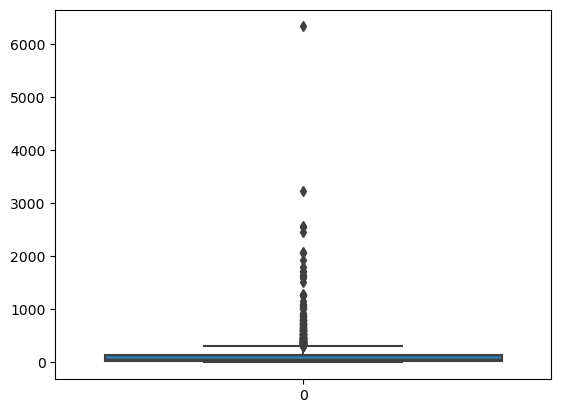

In [88]:
sns.boxplot(data['TotalGHGEmissions'])

In [89]:
data.sort_values(by='TotalGHGEmissions', ascending=False).head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
1407          49940      2016  NonResidential            Hospital   
920           23113      2016  NonResidential      Medical Office   
194             389      2016  NonResidential               Hotel   
1374          45927      2016  NonResidential          Laboratory   
41               63      2016  NonResidential               Hotel   

                              PropertyName                Address     City  \
1407  Virginia Mason Medical Center - 2149         925 Seneca St.  Seattle   
920                         Central Campus       201 16Th Ave. E.  Seattle   
194               Fairmont Olympic Seattle  411 University Street  Seattle   
1374       Reasearch and Training Building       300 Ninth Avenue  Seattle   
41                  Sheraton Seattle Hotel        1400 6Th Avenue  Seattle   

     State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
1407    WA  98101.0                    1979200210                    3   
920     WA  98112.0                    3117000005                    3   
194     WA  98101.0                    0002400003                    7   
1374    WA  98104.0                    8590900220                    3   
41      WA  98101.0                    1976700095                    7   

     Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
1407         East  47.60986 -122.32774       1920                1.0   
920          East  47.62014 -122.31228       1964                1.0   
194      Downtown  47.60804 -122.33391       1923                1.0   
1374         East  47.60427 -122.32311       2000                1.0   
41       Downtown  47.61087 -122.33339       1982                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
1407               8            374466                   0   
920                3            591981                   0   
194               12            542305                   0   
1374               8            178000                   0   
41                34            994212              146694   

      PropertyGFABuilding(s)  \
1407                  374466   
920                   591981   
194                   542305   
1374                  178000   
41                    847518   

                              ListOfAllPropertyUseTypes  \
1407              Hospital (General Medical & Surgical)   
920   Medical Office, Other/Specialty Hospital, Outp...   
194                                Hotel, Swimming Pool   
1374                                         Laboratory   
41                        Hotel, Parking, Swimming Pool   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
1407  Hospital (General Medical & Surgical)                  1010135.0   
920                          Medical Office                   520187.0   
194                                   Hotel                   542305.0   
1374                             Laboratory                   181930.0   
41                                    Hotel                   994212.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
1407                         None                              0.0   
920                       Parking                         282392.0   
194                 Swimming Pool                              0.0   
1374                         None                              0.0   
41                        Parking                         117668.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
1407                        None                             0.0   
920     Other/Specialty Hospital                         54159.0   
194                         None                             0.0   
1374                        None                             0.0   
41                 Swimming Pool                             0.0   

     YearsENERGYSTARCertified  ENERGYSTARScore  

<Axes: xlabel='TotalGHGEmissions', ylabel='PrimaryPropertyType'>

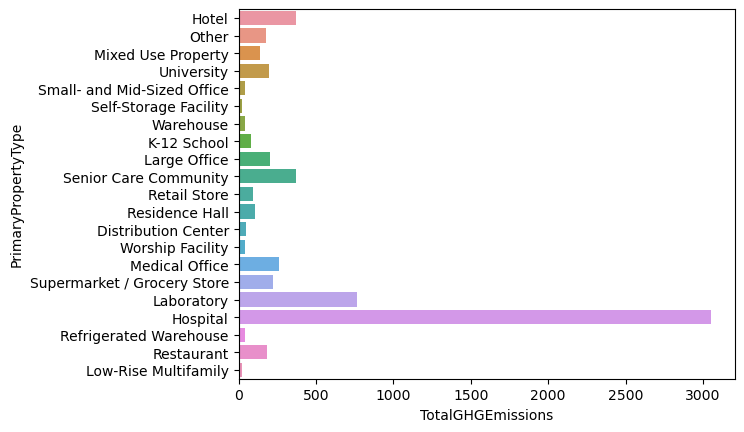

In [90]:
sns.barplot(data=data, y='PrimaryPropertyType', x='TotalGHGEmissions', errorbar=None)
#plt.xticks(rotation=90)

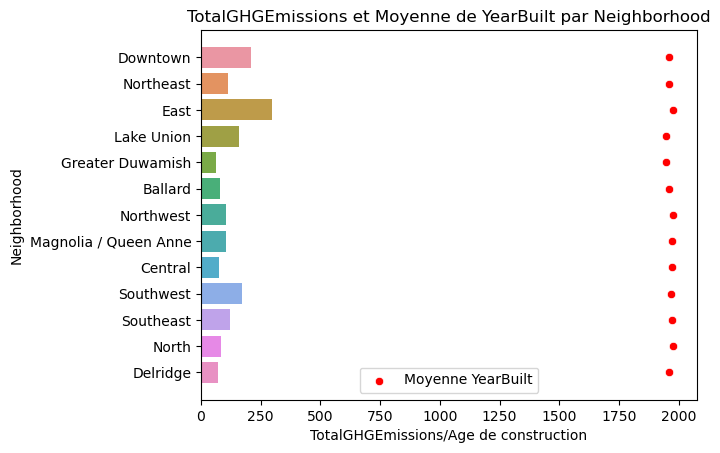

In [91]:
# Tracé des barres pour 'TotalGHGEmissions'
sns.barplot(data=data, y='Neighborhood', x='TotalGHGEmissions', errorbar=None)

# Calcul de la moyenne de 'YearBuilt' par 'Neighborhood'
mean_year_built = data.groupby('Neighborhood')['YearBuilt'].mean().reset_index()

# Tracé de la ligne pour la moyenne de 'YearBuilt'
sns.scatterplot(data=mean_year_built, y='Neighborhood', x='YearBuilt', marker='o', color='red', label='Moyenne YearBuilt')

# Configuration du titre et des étiquettes d'axe
plt.title('TotalGHGEmissions et Moyenne de YearBuilt par Neighborhood')
plt.xlabel('TotalGHGEmissions/Age de construction')
plt.ylabel('Neighborhood')

# Affichage du graphique
plt.show()

In [92]:
# Calculer la moyenne de 'TotalGHGEmissions'
mean_ghg_emissions = data['TotalGHGEmissions'].mean()

# Calculer l'écart-type de 'TotalGHGEmissions' pour ajuster les limites de l'échelle de couleurs
std_ghg_emissions = data['TotalGHGEmissions'].std()

# Créer une carte centrée sur Seattle
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=11)

# Créer un groupe de marqueurs pour les quartiers
marker_cluster = MarkerCluster().add_to(seattle_map)

# Définir l'échelle de couleurs basée sur la moyenne
color_scale = folium.LinearColormap(colors=['green', 'yellow', 'red'], vmin=mean_ghg_emissions - std_ghg_emissions, vmax=mean_ghg_emissions + std_ghg_emissions)

# Ajouter des marqueurs pour chaque quartier avec un dégradé de couleur en fonction de 'TotalGHGEmissions'
for i, row in data.iterrows():
    radius = row['PropertyGFATotal'] / 5000 
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        popup=f"{row['PrimaryPropertyType']} <br>Address: {row['Address']}<br>TotalGHGEmissions: {row['TotalGHGEmissions']}",
        color='blue',
        fill=True,
        fill_color=color_scale(row['TotalGHGEmissions']),
        fill_opacity=0.7
    ).add_to(marker_cluster)
    
# Ajouter une échelle de couleur à la carte
color_scale.caption = 'TotalGHGEmissions'
color_scale.add_to(seattle_map)

# Afficher la carte
seattle_map.save('seattle_map.html')
seattle_map


**SYNTHESE**

- La variable TotalGHGEmissions est une variable continue.
- Il y a un outlier -> regardons notre varaible cible avec PrimaryPropertyType. Ce n'est pas un outlier, elle est cohérente avec le type de batiment
- On remarque qu'en fonction du quartier les emissions ne sont pas les mêmes. La question est de savoir quels hypothèses on peut emettre sur les facteurs.
- L'année de construction n'est pas un facteur expliquant la différence entre les quartiers
- En placant les batiments sur la carte de seattle on fonction de TotalGHGEmissions et de la taille des batiments nous n'avons pas de tendance qui se dégage. 

### SiteEnergyUse(kBtu)

<Axes: xlabel='SiteEnergyUse(kBtu)', ylabel='PrimaryPropertyType'>

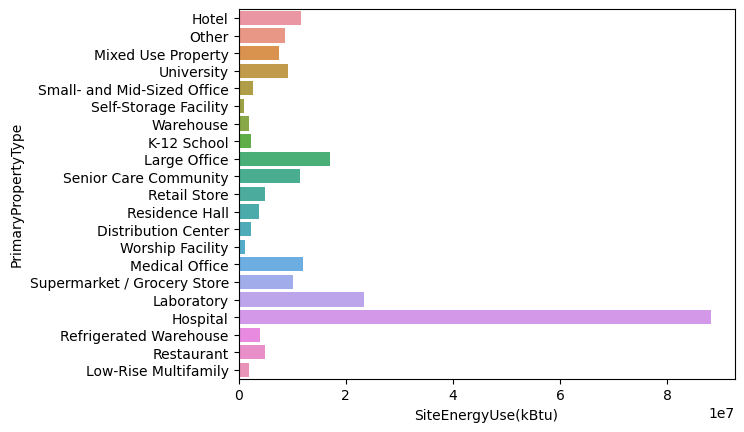

In [93]:
sns.barplot(data=data, y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)', errorbar=None)

<Axes: xlabel='YearBuilt', ylabel='SiteEnergyUse(kBtu)'>

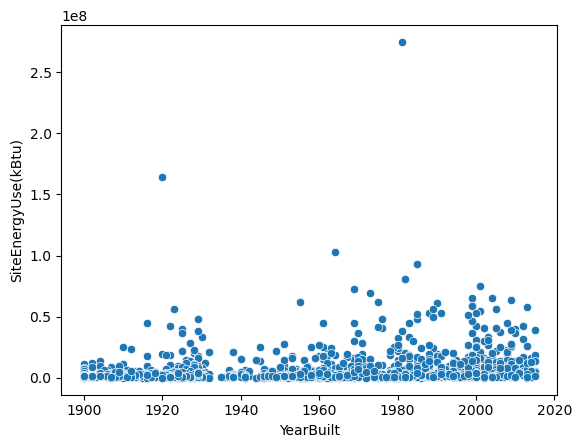

In [94]:
sns.scatterplot(data=data, x='YearBuilt', y='SiteEnergyUse(kBtu)')

In [95]:
# Initialiser les compteurs
Vrai = 0
Faux = 0
differences = []

# Vérifier si SiteEnergyUse(kBtu) correspond au total des énergies recensées (en kBtu) pour chaque bâtiment
for i in range(len(data)):
    site_energy = data['SiteEnergyUse(kBtu)'].iloc[i]
    total_energy = data['SteamUse(kBtu)'].iloc[i] + data['Electricity(kBtu)'].iloc[i] + data['NaturalGas(kBtu)'].iloc[i]

    # Comparer la somme des énergies pour chaque bâtiment
    if site_energy == total_energy:
        Vrai += 1
    else:
        Faux += 1
        difference = site_energy - total_energy
        differences.append(difference)

# Afficher les résultats
print(f"{Vrai} bâtiments dont la somme énergétique est juste, {Faux} bâtiments dont la somme énergétique n'est pas juste")

# Créer un countplot pour visualiser les différences
sns.scatterplot(differences)
plt.xlabel('batiment')
plt.ylabel('Différence')
plt.show()

221 bâtiments dont la somme énergétique est juste, 1228 bâtiments dont la somme énergétique n'est pas juste


**SYNTHESE**

- Il y a une corrélation significative entre le type de propriété et l'énergie consommé
- Il n'y a pas de corrélation significative entre l'année de construction du batiment et la consommation energétique
- La variable indiquant la consommation de chaque batiment n'est pas la somme des variables énergétiques pour certain batiment. 

## PRE-TRAITEMENT

### Feature engineering - Model_1


In [96]:
data_model_1 = data.copy()

In [97]:
# Changeons les années de construction en age par rapport à DataYear.
data_model_1['AgeBuilt']=data['DataYear']-data['YearBuilt']
data_model_1.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [98]:
# On supprimera les 2 variables (DataYear) et (YearBuilt)
data_model_1 = data_model_1.drop(['DataYear','YearBuilt'], axis=1)
data_model_1.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000

On peut a partir des propriétés GFA modifier les variables en % et supprimer la variables totale.

In [99]:
data_model_1['PropertyGFAParking(%)'] = round(data_model_1['PropertyGFAParking']/data_model_1['PropertyGFATotal']*100,3)
data_model_1['PropertyGFABuilding(s)(%)'] = round(data_model_1['PropertyGFABuilding(s)']/data_model_1['PropertyGFATotal']*100,3)
data_model_1.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000

In [100]:
data_model_1 = data_model_1.drop(['PropertyGFAParking','PropertyGFABuilding(s)'], axis=1)

In [101]:
data_model_1.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2                          Hotel                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                         None   
1                    83880.0                      Parking   
2                   756493.0                         None   
3                    61320.0                         None   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              0.0                        None   
1                          15064.0                  Restaurant   
2                              0.0                        None   
3                              0.0                        None   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                             0.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
4                             0.0                      NaN             75.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           97.900002          176.100006   
2         96.000000           97.699997          241.899994   
3        110.800003          113.300003          216.199997   
4        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006           72587024.0             73937112.0   
3            224.000000            6794584.0              6946800.5 

Nous allons créer de nouvelles variables à partir des données énergétiques :
- Source_principale
- Source_secondaire
- Source_tertiaire

In [102]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

source = ['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']

# Initialiser les colonnes
data_model_1['Source_principale'] = ''
data_model_1['Source_secondaire'] = ''
data_model_1['Source_tertiaire'] = ''

# Parcourir les lignes du DataFrame
for i in range(len(data_model_1)):
    # Calculer les pourcentages pour chaque source
    percentages = pd.DataFrame({'Pourcentage': [data_model_1[x].iloc[i] / data_model_1['SiteEnergyUseWN(kBtu)'].iloc[i] * 100 for x in source]}, index=source)


    # Remplacer l'index de la source par 'Aucune' si la valeur est égale à zéro
    percentages = percentages.rename(index={source[idx]: 'None' for idx, val in enumerate(percentages['Pourcentage']) if val == 0})

    # Obtenir l'ordre trié des sources
    sorted_sources = percentages.sort_values(by='Pourcentage', ascending=False).index.tolist()

    # Attribuer les sources triées aux colonnes
    data_model_1.at[i, 'Source_principale'] = sorted_sources[0]
    data_model_1.at[i, 'Source_secondaire'] = sorted_sources[1]
    data_model_1.at[i, 'Source_tertiaire'] = sorted_sources[2]


In [103]:
data_model_1.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2                          Hotel                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                         None   
1                    83880.0                      Parking   
2                   756493.0                         None   
3                    61320.0                         None   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              0.0                        None   
1                          15064.0                  Restaurant   
2                              0.0                        None   
3                              0.0                        None   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                             0.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
4                             0.0                      NaN             75.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           97.900002          176.100006   
2         96.000000           97.699997          241.899994   
3        110.800003          113.300003          216.199997   
4        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0            189.000000            7226362.5              7456910.0   
1            179.399994            8387933.0              8664479.0   
2            244.100006           72587024.0             73937112.0   
3            224.000000            6794584.0              6946800.5 

In [104]:
# On supprime les variables 
data_model_1 = data_model_1.drop(['SiteEnergyUseWN(kBtu)','SteamUse(kBtu)',
                                  'Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)',
                                  'NaturalGas(kBtu)', 'PropertyName', 'Address', 'City', 'State'], axis=1)

In [105]:
print('Nombre de bâtiment restant :', data_model_1.shape[0])

Nombre de bâtiment restant : 1449


In [106]:
data_model_1.head()

OSEBuildingID    BuildingType PrimaryPropertyType  ZipCode  \
0              1  NonResidential               Hotel  98101.0   
1              2  NonResidential               Hotel  98101.0   
2              3  NonResidential               Hotel  98101.0   
3              5  NonResidential               Hotel  98101.0   
4              8  NonResidential               Hotel  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2                          Hotel                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                         None   
1                    83880.0                      Parking   
2                   756493.0                         None   
3                    61320.0                         None   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              0.0                        None   
1                          15064.0                  Restaurant   
2                              0.0                        None   
3                              0.0                        None   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                             0.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
4                             0.0                      NaN             75.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003          182.500000   
1         94.800003           97.900002          176.100006   
2         96.000000           97.699997          241.899994   
3        110.800003          113.300003          216.199997   
4        114.800003          118.699997          211.399994   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu) ComplianceStatus  \
0            189.000000            7226362.5        Compliant   
1            179.399994            8387933.0        Compliant   
2            244.100006           72587024.0        Compliant   
3            224.000000            6794584.0        Compliant   
4            215.600006           14172606.0        Compliant   

   TotalGHGEmissions  GHGEmissionsIntensity  AgeBuilt  PropertyGFAParking(%)  \
0             249.98                   2.83        89                  0.000   
1             295.86                   2.86        20                 14.545   
2            2089.28                   2.19        47                 20.575   
3             286.43                  

In [107]:
col_model_1_quantitative = ['Latitude', 'Longitude', 'LargestPropertyUseTypeGFA', 
                            'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA', 
                             'PropertyGFABuilding(s)(%)']

col_model_1_categoriel = ['BuildingType','PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
                          'NumberofFloors','LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'ComplianceStatus'
                         , 'AgeBuilt', 'Source_principale','Source_secondaire','Source_tertiaire']

col_target = ['TotalGHGEmissions','SiteEnergyUse(kBtu)']

In [108]:
data_model_1 = data_model_1[col_model_1_quantitative + col_model_1_categoriel + col_target]

In [109]:
# On supprime la target 'SiteEnergyUse' qui est correlé TotalGHGEmissions
data_model_1 = data_model_1.drop('SiteEnergyUse(kBtu)', axis=1)

In [110]:
print('Nombre de bâtiment restant :', data_model_1.shape[0])

Nombre de bâtiment restant : 1449


In [111]:
data_model_1.head()

Latitude  Longitude  LargestPropertyUseTypeGFA  \
0  47.61220 -122.33799                    88434.0   
1  47.61317 -122.33393                    83880.0   
2  47.61393 -122.33810                   756493.0   
3  47.61412 -122.33664                    61320.0   
4  47.61375 -122.34047                   123445.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   

   PropertyGFABuilding(s)(%)    BuildingType PrimaryPropertyType  ZipCode  \
0                    100.000  NonResidential               Hotel  98101.0   
1                     85.455  NonResidential               Hotel  98101.0   
2                     79.425  NonResidential               Hotel  98101.0   
3                    100.000  NonResidential               Hotel  98101.0   
4                     64.688  NonResidential               Hotel  98121.0   

   CouncilDistrictCode Neighborhood  NumberofBuildings  NumberofFloors  \
0                    7     Downtown                1.0              12   
1                    7     Downtown                1.0              11   
2                    7     Downtown                1.0              41   
3                    7     Downtown                1.0              10   
4                    7     Downtown                1.0              18   

  LargestPropertyUseType SecondLargestPropertyUseType  \
0                  Hotel                         None   
1                  Hotel                      Parking   
2                  Hotel                         None   
3                  Hotel                         None   
4                  Hotel                      Parking   

  ThirdLargestPropertyUseType ComplianceStatus  AgeBuilt  Source_principale  \
0                        None        Compliant        89  Electricity(kBtu)   
1                  Restaurant        Compliant        20   NaturalGas(kBtu)   
2                        None        Compliant        47  Electricity(kBtu)   
3                        None        Compliant        90  Electricity(kBtu)   
4               Swimming Pool        Compliant        36   NaturalGas(kBtu)   

   Source_secondaire  Source_tertiaire  TotalGHGEmissions  
0     SteamUse(kBtu)  NaturalGas(kBtu)             249.98  
1  Electricity(kBtu)              None             295.86  
2     SteamUse(kBtu)  NaturalGas(kBtu)            2089.28  
3     SteamUse(kBtu)  NaturalGas(kBtu)             286.43  
4  Electricity(kBtu)              None             505.01

In [112]:
# Enregistrer le DataFrame du modele 1
data_model_1.to_csv('data_model_1.csv', index=False)

### Feature engineering - Model_2

In [113]:
data_model_2 = data.copy()

In [114]:
# Changeons les années de construction en age par rapport à DataYear.
data_model_2['AgeBuilt']=data['DataYear']-data['YearBuilt']
data_model_2.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [115]:
# On supprimera les 2 variables (DataYear) et (YearBuilt)
data_model_2 = data_model_2.drop(['DataYear','YearBuilt'], axis=1)
data_model_2.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000

In [116]:
data_model_2['PropertyGFAParking(%)'] = round(data_model_2['PropertyGFAParking']/data_model_2['PropertyGFATotal']*100,3)
data_model_2['PropertyGFABuilding(s)(%)'] = round(data_model_2['PropertyGFABuilding(s)']/data_model_2['PropertyGFATotal']*100,3)
data_model_2.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000

In [117]:
data_model_2 = data_model_2.drop(['PropertyGFAParking','PropertyGFABuilding(s)'], axis=1)

Nous allons créer de nouvelles variables à partir des données énergétiques :
- Source_principale
- Source_secondaire
- Source_tertiaire

In [118]:
source = ['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']

# Initialiser les colonnes
data_model_2['Source_principale'] = ''
data_model_2['Source_secondaire'] = ''
data_model_2['Source_tertiaire'] = ''

# Parcourir les lignes du DataFrame
for i in range(len(data_model_2)):
    # Calculer les pourcentages pour chaque source
    percentages = pd.DataFrame({'Pourcentage': [data_model_2[x].iloc[i] / data_model_2['SiteEnergyUseWN(kBtu)'].iloc[i] * 100 for x in source]}, index=source)


    # Remplacer l'index de la source par 'Aucune' si la valeur est égale à zéro
    percentages = percentages.rename(index={source[idx]: 'None' for idx, val in enumerate(percentages['Pourcentage']) if val == 0})

    # Obtenir l'ordre trié des sources
    sorted_sources = percentages.sort_values(by='Pourcentage', ascending=False).index.tolist()

    # Attribuer les sources triées aux colonnes
    data_model_2.at[i, 'Source_principale'] = sorted_sources[0]
    data_model_2.at[i, 'Source_secondaire'] = sorted_sources[1]
    data_model_2.at[i, 'Source_tertiaire'] = sorted_sources[2]


In [119]:
# On supprime les variables 
data_model_2 = data_model_2.drop(['SiteEnergyUseWN(kBtu)','SteamUse(kBtu)',
                                  'Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)', 'PropertyName'
                                 , 'Address', 'City', 'State'], axis=1)

In [120]:
print('Nombre de bâtiment restant :', data_model_2.shape[0])

Nombre de bâtiment restant : 1449


In [121]:
col_model_2_quantitative = ['Latitude', 'Longitude', 'LargestPropertyUseTypeGFA', 
                            'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                             'PropertyGFABuilding(s)(%)']

col_model_2_categoriel = ['BuildingType','PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
                          'NumberofFloors','LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'ComplianceStatus'
                         , 'AgeBuilt', 'Source_principale','Source_secondaire','Source_tertiaire']

col_target = ['TotalGHGEmissions','SiteEnergyUse(kBtu)']

In [122]:
data_model_2 = data_model_2[col_model_2_quantitative + col_model_2_categoriel + col_target]

In [123]:
# On supprime la target 'TotalGHGEmissions' qui est correlé SiteEnergyUse
data_model_2 = data_model_2.drop('TotalGHGEmissions', axis=1)

In [124]:
# Enregistrer le DataFrame du modele 2
data_model_2.to_csv('data_model_2.csv', index=False)

### Feature engineering - Model_3

In [140]:
data_model_3 = data.copy()

In [141]:
# Changeons les années de construction en age par rapport à DataYear.
data_model_3['AgeBuilt']=data['DataYear']-data['YearBuilt']
data_model_3.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [142]:
# On supprimera les 2 variables (DataYear) et (YearBuilt)
data_model_3 = data_model_3.drop(['DataYear','YearBuilt'], axis=1)
data_model_3.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000

In [143]:
data_model_3['PropertyGFAParking(%)'] = round(data_model_3['PropertyGFAParking']
                                              /data_model_3['PropertyGFATotal']*100,3)
data_model_3['PropertyGFABuilding(s)(%)'] = round(data_model_3['PropertyGFABuilding(s)']
                                                  /data_model_3['PropertyGFATotal']*100,3)

data_model_3.head()

OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive Way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine Street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5Th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 Stewart St  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 Lenora St  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     Downtown  47.61220   
1                    0659000220                    7     Downtown  47.61317   
2                    0659000475                    7     Downtown  47.61393   
3                    0659000640                    7     Downtown  47.61412   
4                    0659000970                    7     Downtown  47.61375   

   Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799                1.0              12             88434   
1 -122.33393                1.0              11            103566   
2 -122.33810                1.0              41            956110   
3 -122.33664                1.0              10             61320   
4 -122.34047                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                         None                              0.0   
1                      Parking                          15064.0   
2                         None                              0.0   
3                         None                              0.0   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                        None                             0.0   
1                  Restaurant                          4622.0   
2                        None                             0.0   
3                        None                             0.0   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000

In [144]:
data_model_3 = data_model_3.drop(['PropertyGFAParking','PropertyGFABuilding(s)'], axis=1)

Nous allons créer de nouvelles variables à partir des données énergétiques :
- Source_principale
- Source_secondaire
- Source_tertiaire

In [145]:
source = ['Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']

# Initialiser les colonnes
data_model_3['Source_principale'] = ''
data_model_3['Source_secondaire'] = ''
data_model_3['Source_tertiaire'] = ''

# Parcourir les lignes du DataFrame
for i in range(len(data_model_3)):
    # Calculer les pourcentages pour chaque source
    percentages = pd.DataFrame({'Pourcentage': [data_model_3[x].iloc[i] /data_model_3['SiteEnergyUseWN(kBtu)']
                                                .iloc[i] * 100 for x in source]}, index=source)


    # Remplacer l'index de la source par 'Aucune' si la valeur est égale à zéro
    percentages = percentages.rename(index={source[idx]: 'None' for idx, 
                                            val in enumerate(percentages['Pourcentage']) if val == 0})

    # Obtenir l'ordre trié des sources
    sorted_sources = percentages.sort_values(by='Pourcentage', ascending=False).index.tolist()

    # Attribuer les sources triées aux colonnes
    data_model_3.at[i, 'Source_principale'] = sorted_sources[0]
    data_model_3.at[i, 'Source_secondaire'] = sorted_sources[1]
    data_model_3.at[i, 'Source_tertiaire'] = sorted_sources[2]


In [146]:
# On supprime les variables 
data_model_3 = data_model_3.drop(['SiteEnergyUseWN(kBtu)','SteamUse(kBtu)',
                                  'Electricity(kWh)','Electricity(kBtu)',
                                  'NaturalGas(therms)','NaturalGas(kBtu)', 'PropertyName',
                                'Address', 'City', 'State'], axis=1)

In [147]:
print('Nombre de bâtiment restant :', data_model_3.shape[0])

Nombre de bâtiment restant : 1449


In [148]:
col_model_3_quantitative = ['Latitude', 'Longitude', 'LargestPropertyUseTypeGFA', 
                            'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                             'PropertyGFABuilding(s)(%)', 'ENERGYSTARScore']

col_model_3_categoriel = ['BuildingType','PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode',
                          'Neighborhood', 'NumberofBuildings',
                          'NumberofFloors','LargestPropertyUseType', 'SecondLargestPropertyUseType',
                          'ThirdLargestPropertyUseType', 'ComplianceStatus',
                          'AgeBuilt', 'Source_principale','Source_secondaire','Source_tertiaire']

col_target = ['TotalGHGEmissions']

In [149]:
data_model_3 = data_model_3[col_model_3_quantitative + col_model_3_categoriel + col_target]

In [150]:
display(data_model_3.head())

Latitude  Longitude  LargestPropertyUseTypeGFA  \
0     47.61220 -122.33799                    88434.0   
1     47.61317 -122.33393                    83880.0   
2     47.61393 -122.33810                   756493.0   
3     47.61412 -122.33664                    61320.0   
4     47.61375 -122.34047                   123445.0   
...        ...        ...                        ...   
1444  47.54067 -122.37441                    18261.0   
1445  47.59625 -122.32283                    16000.0   
1446  47.63644 -122.35784                     7583.0   
1447  47.52832 -122.32431                     6601.0   
1448  47.53939 -122.29536                     8271.0   

      SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                                 0.0                             0.0   
1                             15064.0                          4622.0   
2                                 0.0                             0.0   
3                                 0.0                             0.0   
4                             68009.0                             0.0   
...                               ...                             ...   
1444                              0.0                             0.0   
1445                              0.0                             0.0   
1446                           5574.0                             0.0   
1447                           6501.0                           484.0   
1448                           8000.0                          1108.0   

      PropertyGFABuilding(s)(%)  ENERGYSTARScore        BuildingType  \
0                       100.000             60.0      NonResidential   
1                        85.455             61.0      NonResidential   
2                        79.425             43.0      NonResidential   
3                       100.000             56.0      NonResidential   
4                        64.688             75.0      NonResidential   
...                         ...              ...                 ...   
1444                    100.000              NaN  Nonresidential COS   
1445                    100.000              NaN  Nonresidential COS   
1446                    100.000              NaN  Nonresidential COS   
1447                    100.000              NaN  Nonresidential COS   
1448                    100.000              NaN  Nonresidential COS   

     PrimaryPropertyType  ZipCode  CouncilDistrictCode           Neighborhood  \
0                  Hotel  98101.0                    7               Downtown   
1                  Hotel  98101.0                    7               Downtown   
2                  Hotel  98101.0                    7               Downtown   
3                  Hotel  98101.0                    7               Downtown   
4                  Hotel  98121.0                    7               Downtown   
...                  ...      ...                  ...                    ...   
1444               Other  98126.0                    1               Delridge   
1445               Other  55075.0                    2               Downtown   
1446               Other  98119.0                    7  Magnolia / Queen Anne   
1447  Mixed Use Property  98108.0                    1       Greater Duwamish   
1448  Mixed Use Property  98108.0                    2       Greater Duwamish   

      NumberofBuildings  NumberofFloors LargestPropertyUseType  \
0                   1.0              12                  Hotel   
1                   1.0              11                  Hotel   
2                   1.0              41                  Hotel   
3                   1.0              10                  Hotel   
4                   1.0              18                  Hotel   
...                 ...             ...                    ...   
1444                1.0               1     Other - Recreation   
1445                1.0               1     Other - Recreation   
1446                1.0 

In [151]:
# Enregistrer le DataFrame du modele 2
data_model_3.to_csv('data_model_3.csv', index=False)